# Image Classification of ATLAS Calorimeter Topo-Clusters

This notebook includes performance comparisons of different Machine Learning techniques for classifying topological clusters in the ATLAS calorimeter. 

### The task

Train a classifier to determine which type of particle generated the parton showers in the cluster (e.g. $e^{\pm}$ vs. $\pi^{\pm}$ or $\pi^0$ vs. $\pi^{\pm}$).

### The cluster images

Each cluster is associated with six 2D images, corresponding to the barrels layers of the EM (EMB1, EMB2, EMB3) and HAD (TileBar0, TileBar2, TileBar3) calorimeters. Normalized (per layer)( calorimeter cell energies are used as pixel values. The image size is $0.4\times0.4$ in $\eta\times\phi$ space.

The following models are implemented:

1. Simple fully-connected Neural Network (flattening the images, developing a separate NN per calo layer).
2. Simple combinations (via a new NN, or combined single deep NN) of the flattened NNs from above.
3. Convolutional Neural Networks using only one layer (preserving the shape of the 2D images).
4. A network with multiple images as inputs, and one output (first couple of ConvNets are trained separately, then flattened and concatenated). 

TODO
- Cleanup code a bit, in particular make it easier to swap samples.
- Probably modify inputs to be just numpy arrays (rather than a dictionary of arrays), makes it easier to slice and dice inputs. 
- Implement a network of concatenated ConvNets taking all calorimeter layer images into account.
- Also compare the performance with other ML algorithms; logistic regression, SVD, Naive Bias, Gaussians, etc.


In [3]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
plotpath = '/global/home/users/mfong/git/LCStudies/classifier/Plots/'
modelpath = '/global/home/users/mfong/git/LCStudies/classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [11]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
ngpu = len(gpus)
print(gpus)
# tf.config.experimental.set_virtual_device_configuration(gpus[3], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16384)]) #in MB
tf.config.experimental.set_memory_growth(gpus[0], True)

[]


IndexError: list index out of range

In [5]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:3"])
# # strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:3',)
Number of devices: 1


## Import the datasets 

The notebook is structured to make the swapping of datasets trivial. 

In [6]:
# import pi+- vs. pi0 images

# seed = 10
# np.random.seed(seed)
path = '/clusterfs/ml4hep/mfong/ML4Pions/v7/'

# TODO fix input files so that it is easier to split up the events
p0 = np.load(path+"pi0.npz")
pp = np.load(path+"piplus.npz")
pm = np.load(path+"piminus.npz")

#clean up to round numbers, which are prefered by tf.keras
#don't actually need this
# p0d = {}
# p0d = {key:p0[key][:180000] for key in p0}
# # p0=p0d

# ppd = {}
# ppd = {key:pp[key][:180000] for key in pp}
# # pp=ppd

# pmd = {}
# pmd = {key:pm[key][:280000] for key in pm}
# pm=pmd

# pc = {}
#concat pp and pm for/ greater stats
# pc = {key:np.append(pp[key], pm[key], 0) for key in pp}
# pp = pc # naughty, just replace it so we don't have to change code later

np0 = len(p0['EMB1'])
npp = len(pp['EMB1'])
npm = len(pm['EMB1'])
# npc = len(pc['EMB1'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
# print("Number of cpi events: {}".format(npc))
print("Total: {}".format(np0+npp+npm))

# print pp['label']
# print pm['label']
# print p0['label']

Number of pi0 events: 81543
Number of pi+ events: 82110
Number of pi- events: 81795
Total: 245448


### Plot a few example images

<Figure size 432x288 with 0 Axes>

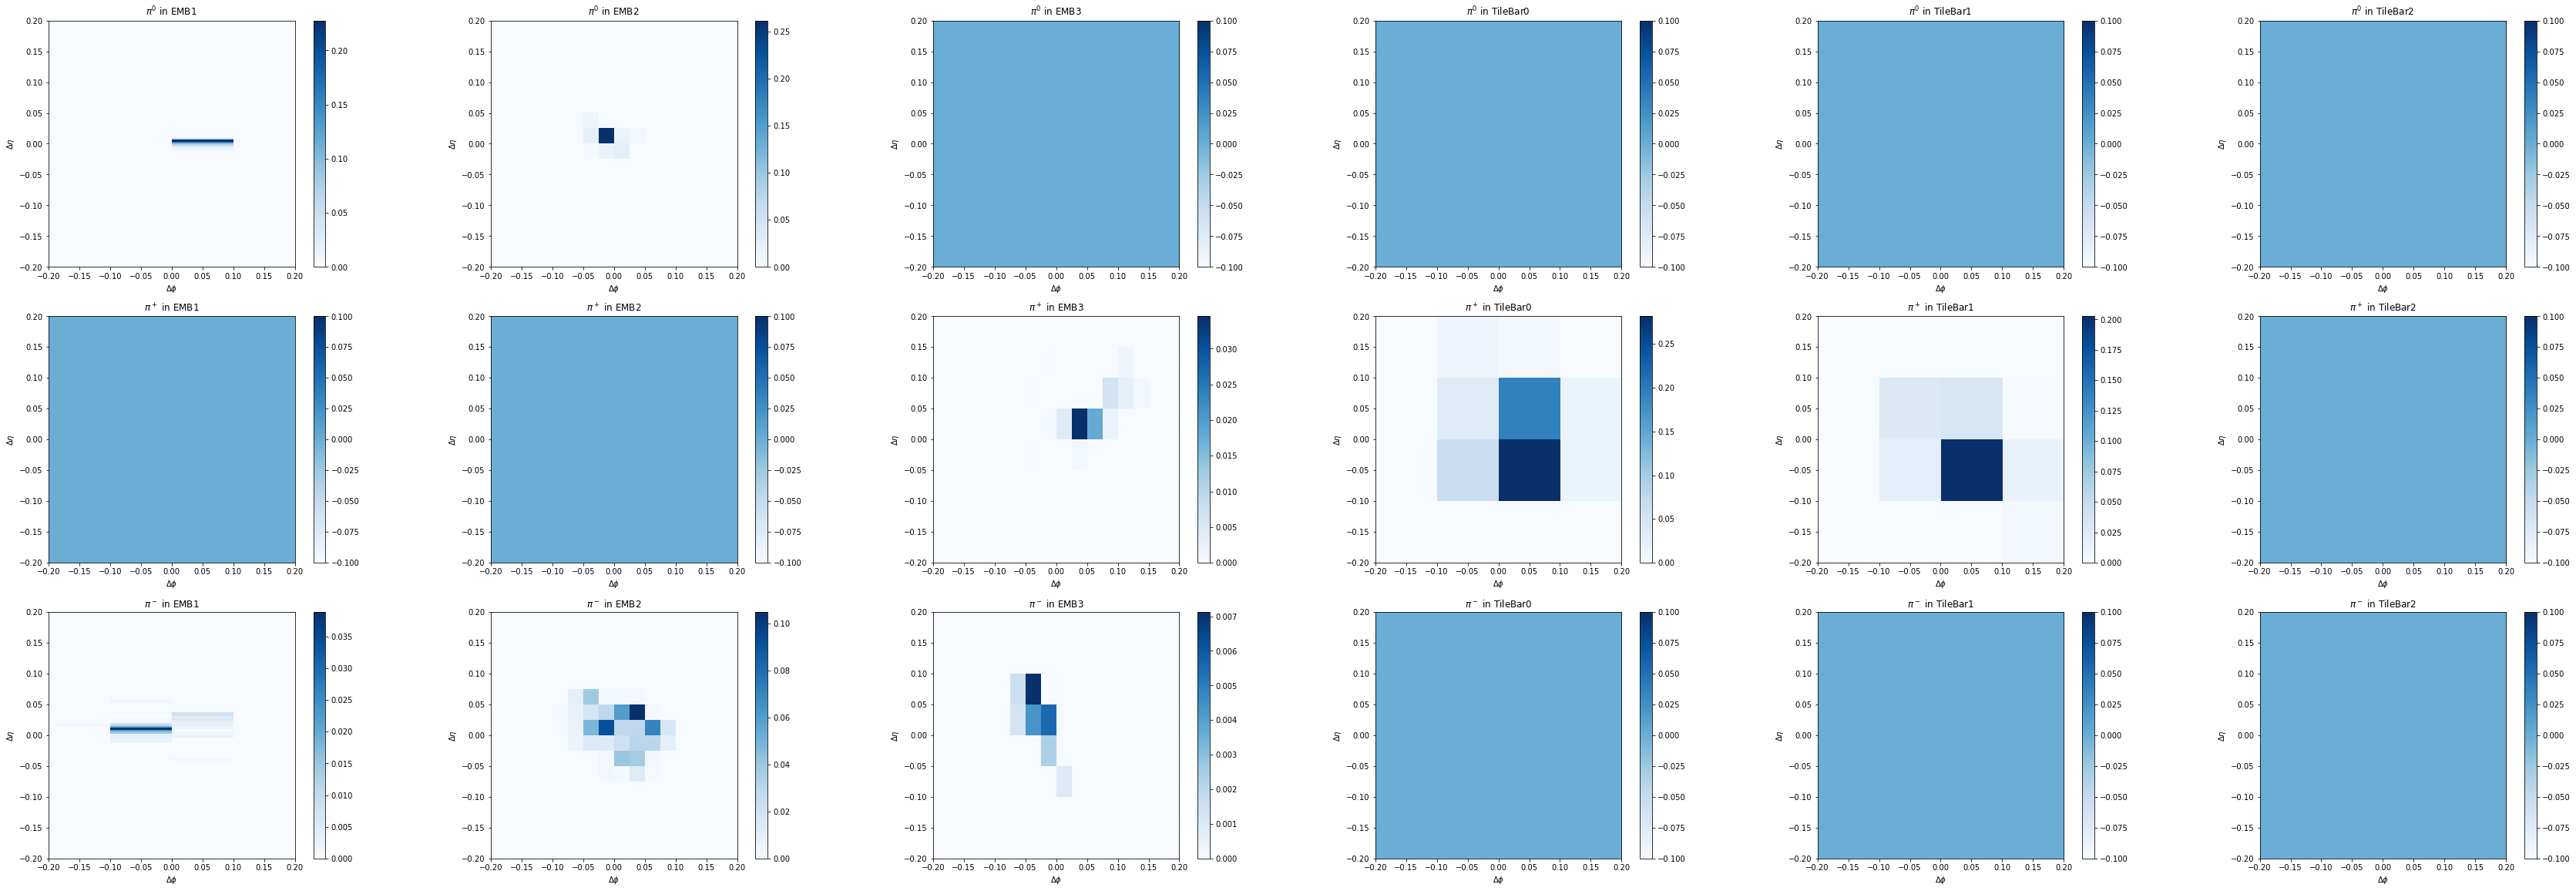

In [4]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 100

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(60,20))
fig.patch.set_facecolor('white')

i = 1
for layer in layers:
    
    # pi0
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(p0[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^0$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi+
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pp[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^+$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi-
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pm[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^-$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.savefig(plotpath+'/plots_pi0_plus_minus.pdf')
plt.show()


### Plot a few histograms

NameError: name 'pion' is not defined

<Figure size 432x288 with 0 Axes>

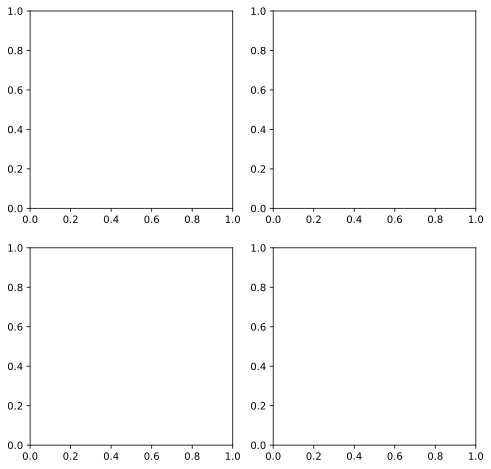

In [86]:
# histograms for pT = 100 GeV electron/pion samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(8,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Pions')
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Electrons')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Pions')
ax[0,1].hist(elec['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Electrons')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,0].hist(elec['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()
#plt.savefig('hist_pion_electron.pdf')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: Mat

<Figure size 432x288 with 0 Axes>

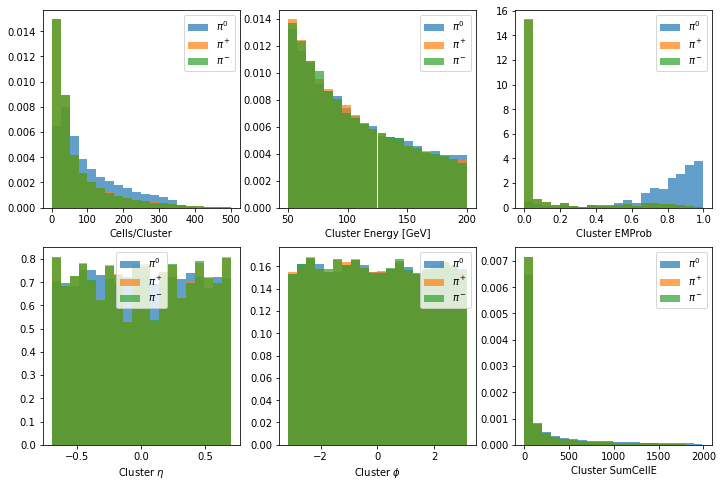

In [5]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=20

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(12,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(p0['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^0$')
ax[0,0].hist(pp['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^+$')
ax[0,0].hist(pm['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^-$')
# ax[0,0].hist(pc['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,0].set_xlabel('Cells/Cluster')
# ax[0,0].text(0.6,0.5,'ATLAS Internal',transform=ax[0,0].transAxes)
ax[0,0].legend()

# cluster energy
ax[0,1].hist(p0['clusterE'], bins=n_bins, normed=True, range=(50,200), alpha=0.7, label='$\pi^0$')
ax[0,1].hist(pp['clusterE'], bins=n_bins, normed=True, range=(50,200), alpha=0.7, label='$\pi^+$')
ax[0,1].hist(pm['clusterE'], bins=n_bins, normed=True, range=(50,200), alpha=0.7, label='$\pi^-$')
# ax[0,1].hist(pc['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(p0['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,0].hist(pp['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,0].hist(pm['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,0].hist(pc['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(p0['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,1].hist(pp['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,1].hist(pm['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

# cluster EM prob
ax[0,2].hist(p0['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[0,2].hist(pp['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[0,2].hist(pm['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[0,2].set_xlabel('Cluster EMProb')
ax[0,2].legend()

# cluster sum cell e
ax[1,2].hist(p0['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,2].hist(pp['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,2].hist(pm['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,2].set_xlabel('Cluster SumCellE')
ax[1,2].legend()

plt.savefig(plotpath+'hist_pi0_plus_minus.pdf')
plt.show()


## 1. Simple feed-forward Neural Network

In [7]:
# # Train on E = 0.5-2000 GeV pi0/pi+/pi- samples

# here, define a function to flatten inputs
def format_flat(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

    X = np.append(data_0[layer].reshape((len(data_0[layer]),num_pixels)),
                  data_1[layer].reshape((len(data_1[layer]),num_pixels)), axis=0)

    y = np.append(data_0['label'], data_1['label'], axis=0)

    print (X.shape)
    print (y.shape)
    return X, y, num_pixels

In [8]:
x_flat = {}
y_flat = {}
num_pixels_flat = {}
for layer_i, layer_name in enumerate(layers):
    x_flat[layer_i], y_flat[layer_i], num_pixels_flat[layer_i] = format_flat(p0, pp, layer_i)

(163653, 512)
(163653, 1)
(163653, 256)
(163653, 1)
(163653, 128)
(163653, 1)
(163653, 16)
(163653, 1)
(163653, 16)
(163653, 1)
(163653, 8)
(163653, 1)


In [11]:
#split up data into separate training, validation, and testing

test_size = 24000
validation_size = 24000
from sklearn.model_selection import train_test_split
def make_split_samples(X, y, test_size, validation_size):
    X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
    X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

    # normalize inputs from 0-255 to 0-1
    # this seems to be done already??
#     X_tr = X_tr / 255
#     X_te = X_te / 255
#     X_vl = X_vl / 255

    # one hot encode outputs
    from keras.utils import np_utils
    y_tr_onehot = np_utils.to_categorical(y_tr, 2)
    y_te_onehot = np_utils.to_categorical(y_te, 2)
    y_vl_onehot = np_utils.to_categorical(y_vl, 2)
    num_classes = y_te_onehot.shape[1]
    print("y_train.shape: ",y_tr.shape)
    print("y_train_onehot.shape: ",y_tr_onehot.shape)
    
    return X_tr, X_te, X_vl, y_tr_onehot, y_te_onehot, y_vl_onehot

In [14]:
x_flat_tr = {}
x_flat_te = {}
x_flat_vl = {}
y_flat_tr_onehot = {}
y_flat_te_onehot = {}
y_flat_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_flat_tr[layer_i], x_flat_te[layer_i], x_flat_vl[layer_i], y_flat_tr_onehot[layer_i], y_flat_te_onehot[layer_i], y_flat_vl_onehot[layer_i] = make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)

y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [16]:
# define baseline fully-connected NN model
def baseline_nn_model(number_pixels):
    # create model
#     with strategy.scope():    
    model = Sequential()
    used_pixels = number_pixels
#     if number_pixels < 128:
#         used_pixels = 128
    model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(used_pixels, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(used_pixels/2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    optimizer = Adam(lr=5e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [17]:
# build the model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    models_flat[layer_i] = baseline_nn_model(num_pixels_flat[layer_i])
    models_flat[layer_i].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5

In [18]:
# now automated with functions
history_flat = {}
scores = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer %s' % (layer_name))
    history_flat[layer_i] = models_flat[layer_i].fit(x_flat_tr[layer_i], y_flat_tr_onehot[layer_i], validation_data=(x_flat_vl[layer_i], y_flat_vl_onehot[layer_i]), epochs = 200, batch_size = 200*ngpu, verbose = 2)
    scores[layer_i] = models_flat[layer_i].evaluate(x_flat_te[layer_i], y_flat_te_onehot[layer_i], verbose = 0)
    print('Finished layer %s' % (layer_name))

On layer EMB1
Epoch 1/200
579/579 - 2s - loss: 0.4666 - acc: 0.8511 - val_loss: 0.3062 - val_acc: 0.8685
Epoch 2/200
579/579 - 1s - loss: 0.2816 - acc: 0.8865 - val_loss: 0.2439 - val_acc: 0.9018
Epoch 3/200
579/579 - 2s - loss: 0.2264 - acc: 0.9143 - val_loss: 0.2009 - val_acc: 0.9236
Epoch 4/200
579/579 - 2s - loss: 0.1925 - acc: 0.9316 - val_loss: 0.1768 - val_acc: 0.9372
Epoch 5/200
579/579 - 2s - loss: 0.1740 - acc: 0.9405 - val_loss: 0.1635 - val_acc: 0.9440
Epoch 6/200
579/579 - 2s - loss: 0.1612 - acc: 0.9461 - val_loss: 0.1527 - val_acc: 0.9489
Epoch 7/200
579/579 - 2s - loss: 0.1521 - acc: 0.9502 - val_loss: 0.1464 - val_acc: 0.9527
Epoch 8/200
579/579 - 2s - loss: 0.1453 - acc: 0.9535 - val_loss: 0.1393 - val_acc: 0.9547
Epoch 9/200
579/579 - 1s - loss: 0.1403 - acc: 0.9553 - val_loss: 0.1344 - val_acc: 0.9557
Epoch 10/200
579/579 - 2s - loss: 0.1366 - acc: 0.9569 - val_loss: 0.1306 - val_acc: 0.9591
Epoch 11/200
579/579 - 2s - loss: 0.1313 - acc: 0.9590 - val_loss: 0.1265 -

Epoch 90/200
579/579 - 1s - loss: 0.0901 - acc: 0.9714 - val_loss: 0.0898 - val_acc: 0.9715
Epoch 91/200
579/579 - 2s - loss: 0.0903 - acc: 0.9711 - val_loss: 0.0913 - val_acc: 0.9706
Epoch 92/200
579/579 - 2s - loss: 0.0901 - acc: 0.9715 - val_loss: 0.0891 - val_acc: 0.9715
Epoch 93/200
579/579 - 2s - loss: 0.0897 - acc: 0.9714 - val_loss: 0.0899 - val_acc: 0.9720
Epoch 94/200
579/579 - 2s - loss: 0.0893 - acc: 0.9720 - val_loss: 0.0891 - val_acc: 0.9720
Epoch 95/200
579/579 - 1s - loss: 0.0898 - acc: 0.9716 - val_loss: 0.0909 - val_acc: 0.9713
Epoch 96/200
579/579 - 1s - loss: 0.0893 - acc: 0.9716 - val_loss: 0.0891 - val_acc: 0.9722
Epoch 97/200
579/579 - 1s - loss: 0.0890 - acc: 0.9722 - val_loss: 0.0917 - val_acc: 0.9712
Epoch 98/200
579/579 - 2s - loss: 0.0897 - acc: 0.9716 - val_loss: 0.0891 - val_acc: 0.9722
Epoch 99/200
579/579 - 2s - loss: 0.0891 - acc: 0.9723 - val_loss: 0.0890 - val_acc: 0.9720
Epoch 100/200
579/579 - 1s - loss: 0.0889 - acc: 0.9721 - val_loss: 0.0888 - val

Epoch 179/200
579/579 - 1s - loss: 0.0816 - acc: 0.9749 - val_loss: 0.0871 - val_acc: 0.9722
Epoch 180/200
579/579 - 1s - loss: 0.0813 - acc: 0.9747 - val_loss: 0.0854 - val_acc: 0.9738
Epoch 181/200
579/579 - 2s - loss: 0.0816 - acc: 0.9748 - val_loss: 0.0854 - val_acc: 0.9735
Epoch 182/200
579/579 - 2s - loss: 0.0815 - acc: 0.9744 - val_loss: 0.0858 - val_acc: 0.9744
Epoch 183/200
579/579 - 2s - loss: 0.0807 - acc: 0.9753 - val_loss: 0.0854 - val_acc: 0.9733
Epoch 184/200
579/579 - 2s - loss: 0.0815 - acc: 0.9746 - val_loss: 0.0856 - val_acc: 0.9748
Epoch 185/200
579/579 - 2s - loss: 0.0810 - acc: 0.9751 - val_loss: 0.0859 - val_acc: 0.9732
Epoch 186/200
579/579 - 2s - loss: 0.0808 - acc: 0.9751 - val_loss: 0.0881 - val_acc: 0.9735
Epoch 187/200
579/579 - 2s - loss: 0.0808 - acc: 0.9751 - val_loss: 0.0854 - val_acc: 0.9737
Epoch 188/200
579/579 - 1s - loss: 0.0808 - acc: 0.9752 - val_loss: 0.0854 - val_acc: 0.9738
Epoch 189/200
579/579 - 2s - loss: 0.0812 - acc: 0.9753 - val_loss: 0.

Epoch 68/200
579/579 - 2s - loss: 0.1007 - acc: 0.9706 - val_loss: 0.0954 - val_acc: 0.9722
Epoch 69/200
579/579 - 2s - loss: 0.1009 - acc: 0.9701 - val_loss: 0.0956 - val_acc: 0.9721
Epoch 70/200
579/579 - 2s - loss: 0.1003 - acc: 0.9704 - val_loss: 0.0941 - val_acc: 0.9724
Epoch 71/200
579/579 - 1s - loss: 0.0997 - acc: 0.9703 - val_loss: 0.0939 - val_acc: 0.9725
Epoch 72/200
579/579 - 1s - loss: 0.0995 - acc: 0.9707 - val_loss: 0.0936 - val_acc: 0.9723
Epoch 73/200
579/579 - 1s - loss: 0.0981 - acc: 0.9710 - val_loss: 0.0933 - val_acc: 0.9725
Epoch 74/200
579/579 - 1s - loss: 0.0986 - acc: 0.9708 - val_loss: 0.0928 - val_acc: 0.9728
Epoch 75/200
579/579 - 2s - loss: 0.0975 - acc: 0.9716 - val_loss: 0.0927 - val_acc: 0.9730
Epoch 76/200
579/579 - 2s - loss: 0.0974 - acc: 0.9713 - val_loss: 0.0921 - val_acc: 0.9731
Epoch 77/200
579/579 - 2s - loss: 0.0963 - acc: 0.9712 - val_loss: 0.0924 - val_acc: 0.9728
Epoch 78/200
579/579 - 2s - loss: 0.0968 - acc: 0.9714 - val_loss: 0.0937 - val_

Epoch 157/200
579/579 - 1s - loss: 0.0803 - acc: 0.9769 - val_loss: 0.0804 - val_acc: 0.9774
Epoch 158/200
579/579 - 1s - loss: 0.0803 - acc: 0.9771 - val_loss: 0.0804 - val_acc: 0.9775
Epoch 159/200
579/579 - 1s - loss: 0.0806 - acc: 0.9771 - val_loss: 0.0816 - val_acc: 0.9771
Epoch 160/200
579/579 - 1s - loss: 0.0802 - acc: 0.9774 - val_loss: 0.0806 - val_acc: 0.9770
Epoch 161/200
579/579 - 1s - loss: 0.0800 - acc: 0.9772 - val_loss: 0.0814 - val_acc: 0.9770
Epoch 162/200
579/579 - 2s - loss: 0.0796 - acc: 0.9773 - val_loss: 0.0796 - val_acc: 0.9772
Epoch 163/200
579/579 - 2s - loss: 0.0798 - acc: 0.9772 - val_loss: 0.0804 - val_acc: 0.9772
Epoch 164/200
579/579 - 2s - loss: 0.0791 - acc: 0.9773 - val_loss: 0.0803 - val_acc: 0.9772
Epoch 165/200
579/579 - 2s - loss: 0.0794 - acc: 0.9776 - val_loss: 0.0809 - val_acc: 0.9773
Epoch 166/200
579/579 - 2s - loss: 0.0794 - acc: 0.9773 - val_loss: 0.0792 - val_acc: 0.9778
Epoch 167/200
579/579 - 2s - loss: 0.0793 - acc: 0.9771 - val_loss: 0.

Epoch 46/200
579/579 - 2s - loss: 0.2019 - acc: 0.9269 - val_loss: 0.1958 - val_acc: 0.9282
Epoch 47/200
579/579 - 2s - loss: 0.2012 - acc: 0.9270 - val_loss: 0.1913 - val_acc: 0.9301
Epoch 48/200
579/579 - 2s - loss: 0.2009 - acc: 0.9272 - val_loss: 0.1926 - val_acc: 0.9289
Epoch 49/200
579/579 - 1s - loss: 0.2001 - acc: 0.9274 - val_loss: 0.1910 - val_acc: 0.9306
Epoch 50/200
579/579 - 1s - loss: 0.1980 - acc: 0.9283 - val_loss: 0.1910 - val_acc: 0.9302
Epoch 51/200
579/579 - 2s - loss: 0.1982 - acc: 0.9289 - val_loss: 0.1901 - val_acc: 0.9304
Epoch 52/200
579/579 - 2s - loss: 0.1971 - acc: 0.9292 - val_loss: 0.1901 - val_acc: 0.9303
Epoch 53/200
579/579 - 2s - loss: 0.1969 - acc: 0.9292 - val_loss: 0.1882 - val_acc: 0.9314
Epoch 54/200
579/579 - 2s - loss: 0.1952 - acc: 0.9294 - val_loss: 0.1917 - val_acc: 0.9312
Epoch 55/200
579/579 - 2s - loss: 0.1940 - acc: 0.9300 - val_loss: 0.1879 - val_acc: 0.9310
Epoch 56/200
579/579 - 2s - loss: 0.1937 - acc: 0.9305 - val_loss: 0.1867 - val_

Epoch 135/200
579/579 - 2s - loss: 0.1531 - acc: 0.9479 - val_loss: 0.1593 - val_acc: 0.9454
Epoch 136/200
579/579 - 2s - loss: 0.1522 - acc: 0.9483 - val_loss: 0.1628 - val_acc: 0.9435
Epoch 137/200
579/579 - 2s - loss: 0.1514 - acc: 0.9483 - val_loss: 0.1635 - val_acc: 0.9433
Epoch 138/200
579/579 - 1s - loss: 0.1517 - acc: 0.9482 - val_loss: 0.1561 - val_acc: 0.9457
Epoch 139/200
579/579 - 1s - loss: 0.1513 - acc: 0.9482 - val_loss: 0.1480 - val_acc: 0.9494
Epoch 140/200
579/579 - 1s - loss: 0.1504 - acc: 0.9489 - val_loss: 0.1429 - val_acc: 0.9505
Epoch 141/200
579/579 - 1s - loss: 0.1510 - acc: 0.9484 - val_loss: 0.1458 - val_acc: 0.9500
Epoch 142/200
579/579 - 2s - loss: 0.1505 - acc: 0.9487 - val_loss: 0.1550 - val_acc: 0.9477
Epoch 143/200
579/579 - 1s - loss: 0.1501 - acc: 0.9498 - val_loss: 0.1461 - val_acc: 0.9494
Epoch 144/200
579/579 - 2s - loss: 0.1514 - acc: 0.9490 - val_loss: 0.1431 - val_acc: 0.9504
Epoch 145/200
579/579 - 2s - loss: 0.1511 - acc: 0.9491 - val_loss: 0.

579/579 - 2s - loss: 0.2841 - acc: 0.9052 - val_loss: 0.2645 - val_acc: 0.9076
Epoch 24/200
579/579 - 2s - loss: 0.2826 - acc: 0.9053 - val_loss: 0.2641 - val_acc: 0.9078
Epoch 25/200
579/579 - 2s - loss: 0.2820 - acc: 0.9059 - val_loss: 0.2635 - val_acc: 0.9084
Epoch 26/200
579/579 - 1s - loss: 0.2820 - acc: 0.9060 - val_loss: 0.2629 - val_acc: 0.9088
Epoch 27/200
579/579 - 2s - loss: 0.2805 - acc: 0.9066 - val_loss: 0.2628 - val_acc: 0.9087
Epoch 28/200
579/579 - 2s - loss: 0.2795 - acc: 0.9067 - val_loss: 0.2624 - val_acc: 0.9089
Epoch 29/200
579/579 - 1s - loss: 0.2797 - acc: 0.9070 - val_loss: 0.2618 - val_acc: 0.9094
Epoch 30/200
579/579 - 2s - loss: 0.2795 - acc: 0.9071 - val_loss: 0.2617 - val_acc: 0.9094
Epoch 31/200
579/579 - 2s - loss: 0.2784 - acc: 0.9072 - val_loss: 0.2613 - val_acc: 0.9100
Epoch 32/200
579/579 - 2s - loss: 0.2785 - acc: 0.9074 - val_loss: 0.2610 - val_acc: 0.9100
Epoch 33/200
579/579 - 2s - loss: 0.2775 - acc: 0.9082 - val_loss: 0.2605 - val_acc: 0.9103
E

579/579 - 2s - loss: 0.2622 - acc: 0.9120 - val_loss: 0.2512 - val_acc: 0.9143
Epoch 113/200
579/579 - 2s - loss: 0.2626 - acc: 0.9117 - val_loss: 0.2516 - val_acc: 0.9136
Epoch 114/200
579/579 - 2s - loss: 0.2626 - acc: 0.9120 - val_loss: 0.2511 - val_acc: 0.9144
Epoch 115/200
579/579 - 1s - loss: 0.2624 - acc: 0.9121 - val_loss: 0.2512 - val_acc: 0.9140
Epoch 116/200
579/579 - 2s - loss: 0.2626 - acc: 0.9117 - val_loss: 0.2514 - val_acc: 0.9137
Epoch 117/200
579/579 - 2s - loss: 0.2625 - acc: 0.9117 - val_loss: 0.2510 - val_acc: 0.9143
Epoch 118/200
579/579 - 2s - loss: 0.2622 - acc: 0.9125 - val_loss: 0.2515 - val_acc: 0.9136
Epoch 119/200
579/579 - 2s - loss: 0.2618 - acc: 0.9119 - val_loss: 0.2509 - val_acc: 0.9143
Epoch 120/200
579/579 - 2s - loss: 0.2622 - acc: 0.9120 - val_loss: 0.2511 - val_acc: 0.9140
Epoch 121/200
579/579 - 2s - loss: 0.2617 - acc: 0.9119 - val_loss: 0.2508 - val_acc: 0.9143
Epoch 122/200
579/579 - 2s - loss: 0.2610 - acc: 0.9124 - val_loss: 0.2512 - val_acc

Finished layer TileBar0
On layer TileBar1
Epoch 1/200
579/579 - 2s - loss: 0.6908 - acc: 0.5124 - val_loss: 0.6868 - val_acc: 0.5013
Epoch 2/200
579/579 - 1s - loss: 0.6740 - acc: 0.7680 - val_loss: 0.6531 - val_acc: 0.9135
Epoch 3/200
579/579 - 1s - loss: 0.6197 - acc: 0.9046 - val_loss: 0.5781 - val_acc: 0.9065
Epoch 4/200
579/579 - 1s - loss: 0.5428 - acc: 0.9001 - val_loss: 0.4984 - val_acc: 0.9057
Epoch 5/200
579/579 - 1s - loss: 0.4760 - acc: 0.9019 - val_loss: 0.4415 - val_acc: 0.9075
Epoch 6/200
579/579 - 2s - loss: 0.4311 - acc: 0.9037 - val_loss: 0.4056 - val_acc: 0.9085
Epoch 7/200
579/579 - 2s - loss: 0.4004 - acc: 0.9054 - val_loss: 0.3808 - val_acc: 0.9097
Epoch 8/200
579/579 - 2s - loss: 0.3786 - acc: 0.9058 - val_loss: 0.3626 - val_acc: 0.9105
Epoch 9/200
579/579 - 2s - loss: 0.3617 - acc: 0.9069 - val_loss: 0.3483 - val_acc: 0.9109
Epoch 10/200
579/579 - 2s - loss: 0.3486 - acc: 0.9078 - val_loss: 0.3368 - val_acc: 0.9117
Epoch 11/200
579/579 - 2s - loss: 0.3384 - acc:

Epoch 90/200
579/579 - 1s - loss: 0.2573 - acc: 0.9121 - val_loss: 0.2483 - val_acc: 0.9164
Epoch 91/200
579/579 - 1s - loss: 0.2565 - acc: 0.9122 - val_loss: 0.2482 - val_acc: 0.9165
Epoch 92/200
579/579 - 1s - loss: 0.2575 - acc: 0.9124 - val_loss: 0.2481 - val_acc: 0.9164
Epoch 93/200
579/579 - 1s - loss: 0.2563 - acc: 0.9121 - val_loss: 0.2480 - val_acc: 0.9166
Epoch 94/200
579/579 - 1s - loss: 0.2570 - acc: 0.9124 - val_loss: 0.2478 - val_acc: 0.9165
Epoch 95/200
579/579 - 1s - loss: 0.2568 - acc: 0.9123 - val_loss: 0.2478 - val_acc: 0.9164
Epoch 96/200
579/579 - 1s - loss: 0.2569 - acc: 0.9125 - val_loss: 0.2478 - val_acc: 0.9168
Epoch 97/200
579/579 - 2s - loss: 0.2570 - acc: 0.9125 - val_loss: 0.2476 - val_acc: 0.9170
Epoch 98/200
579/579 - 2s - loss: 0.2565 - acc: 0.9125 - val_loss: 0.2475 - val_acc: 0.9169
Epoch 99/200
579/579 - 2s - loss: 0.2570 - acc: 0.9126 - val_loss: 0.2485 - val_acc: 0.9172
Epoch 100/200
579/579 - 2s - loss: 0.2558 - acc: 0.9128 - val_loss: 0.2472 - val

Epoch 179/200
579/579 - 1s - loss: 0.2512 - acc: 0.9149 - val_loss: 0.2413 - val_acc: 0.9188
Epoch 180/200
579/579 - 1s - loss: 0.2513 - acc: 0.9148 - val_loss: 0.2415 - val_acc: 0.9191
Epoch 181/200
579/579 - 1s - loss: 0.2502 - acc: 0.9151 - val_loss: 0.2423 - val_acc: 0.9195
Epoch 182/200
579/579 - 2s - loss: 0.2500 - acc: 0.9150 - val_loss: 0.2411 - val_acc: 0.9190
Epoch 183/200
579/579 - 2s - loss: 0.2504 - acc: 0.9149 - val_loss: 0.2412 - val_acc: 0.9191
Epoch 184/200
579/579 - 2s - loss: 0.2518 - acc: 0.9150 - val_loss: 0.2409 - val_acc: 0.9190
Epoch 185/200
579/579 - 2s - loss: 0.2517 - acc: 0.9150 - val_loss: 0.2408 - val_acc: 0.9189
Epoch 186/200
579/579 - 2s - loss: 0.2524 - acc: 0.9149 - val_loss: 0.2411 - val_acc: 0.9192
Epoch 187/200
579/579 - 1s - loss: 0.2520 - acc: 0.9151 - val_loss: 0.2406 - val_acc: 0.9189
Epoch 188/200
579/579 - 1s - loss: 0.2512 - acc: 0.9151 - val_loss: 0.2406 - val_acc: 0.9188
Epoch 189/200
579/579 - 1s - loss: 0.2512 - acc: 0.9148 - val_loss: 0.

Epoch 68/200
579/579 - 2s - loss: 0.3571 - acc: 0.8615 - val_loss: 0.3482 - val_acc: 0.8675
Epoch 69/200
579/579 - 1s - loss: 0.3575 - acc: 0.8614 - val_loss: 0.3480 - val_acc: 0.8678
Epoch 70/200
579/579 - 1s - loss: 0.3586 - acc: 0.8621 - val_loss: 0.3488 - val_acc: 0.8673
Epoch 71/200
579/579 - 1s - loss: 0.3537 - acc: 0.8624 - val_loss: 0.3479 - val_acc: 0.8677
Epoch 72/200
579/579 - 1s - loss: 0.3546 - acc: 0.8628 - val_loss: 0.3488 - val_acc: 0.8675
Epoch 73/200
579/579 - 1s - loss: 0.3535 - acc: 0.8625 - val_loss: 0.3474 - val_acc: 0.8688
Epoch 74/200
579/579 - 2s - loss: 0.3554 - acc: 0.8626 - val_loss: 0.3469 - val_acc: 0.8695
Epoch 75/200
579/579 - 1s - loss: 0.3531 - acc: 0.8633 - val_loss: 0.3472 - val_acc: 0.8688
Epoch 76/200
579/579 - 1s - loss: 0.3520 - acc: 0.8633 - val_loss: 0.3469 - val_acc: 0.8696
Epoch 77/200
579/579 - 2s - loss: 0.3529 - acc: 0.8633 - val_loss: 0.3467 - val_acc: 0.8695
Epoch 78/200
579/579 - 2s - loss: 0.3554 - acc: 0.8638 - val_loss: 0.3468 - val_

Epoch 157/200
579/579 - 1s - loss: 0.3466 - acc: 0.8707 - val_loss: 0.3416 - val_acc: 0.8757
Epoch 158/200
579/579 - 1s - loss: 0.3476 - acc: 0.8707 - val_loss: 0.3390 - val_acc: 0.8774
Epoch 159/200
579/579 - 2s - loss: 0.3463 - acc: 0.8701 - val_loss: 0.3407 - val_acc: 0.8763
Epoch 160/200
579/579 - 2s - loss: 0.3429 - acc: 0.8706 - val_loss: 0.3417 - val_acc: 0.8758
Epoch 161/200
579/579 - 1s - loss: 0.3434 - acc: 0.8704 - val_loss: 0.3413 - val_acc: 0.8758
Epoch 162/200
579/579 - 2s - loss: 0.3467 - acc: 0.8704 - val_loss: 0.3445 - val_acc: 0.8745
Epoch 163/200
579/579 - 2s - loss: 0.3460 - acc: 0.8713 - val_loss: 0.3391 - val_acc: 0.8774
Epoch 164/200
579/579 - 2s - loss: 0.3449 - acc: 0.8712 - val_loss: 0.3376 - val_acc: 0.8780
Epoch 165/200
579/579 - 2s - loss: 0.3444 - acc: 0.8712 - val_loss: 0.3416 - val_acc: 0.8756
Epoch 166/200
579/579 - 1s - loss: 0.3453 - acc: 0.8709 - val_loss: 0.3405 - val_acc: 0.8764
Epoch 167/200
579/579 - 2s - loss: 0.3475 - acc: 0.8710 - val_loss: 0.

In [19]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    models_flat[layer_i].save(modelpath+'model_{}_flat_do20.h5'.format(layer_name))

Saving EMB1
Saving EMB2
Saving EMB3
Saving TileBar0
Saving TileBar1
Saving TileBar2


In [20]:
#alternate to fitting the model: load a saved model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    print('Loading {}'.format(layer_name))
    models_flat[layer_i] = tf.keras.models.load_model(modelpath+'model_{}_flat_do20.h5'.format(layer_name))

Loading EMB1
Loading EMB2
Loading EMB3
Loading TileBar0
Loading TileBar1
Loading TileBar2


<Figure size 432x288 with 0 Axes>

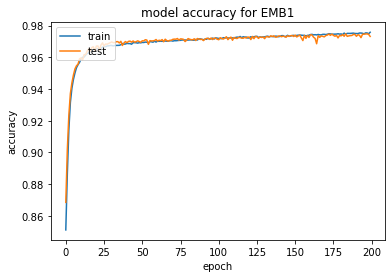

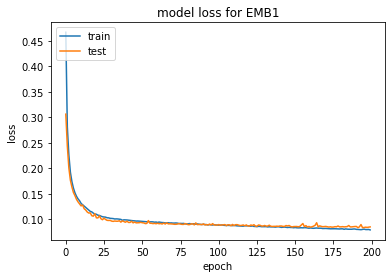

<Figure size 432x288 with 0 Axes>

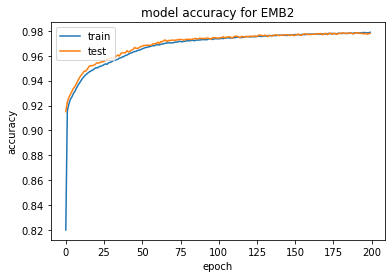

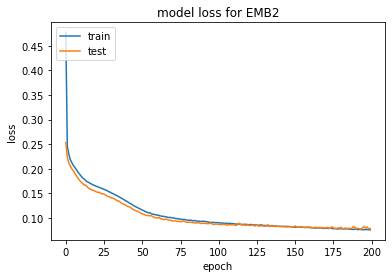

<Figure size 432x288 with 0 Axes>

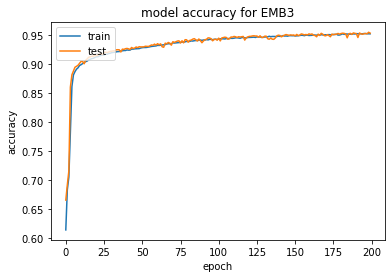

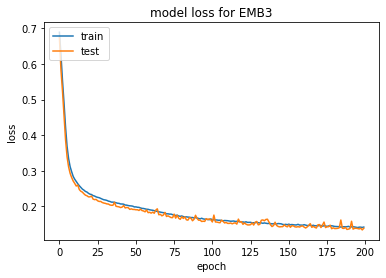

<Figure size 432x288 with 0 Axes>

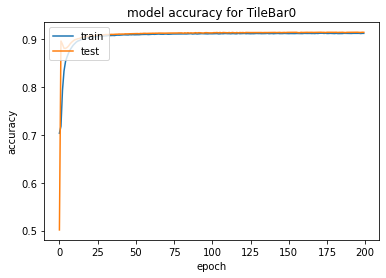

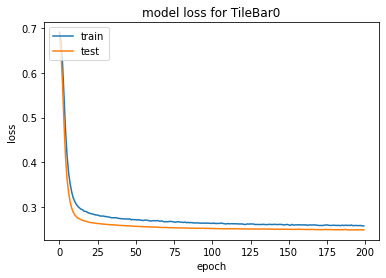

<Figure size 432x288 with 0 Axes>

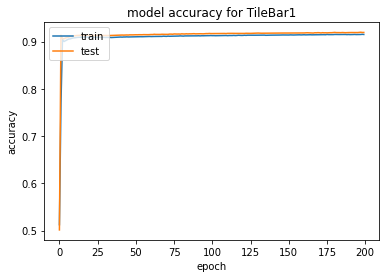

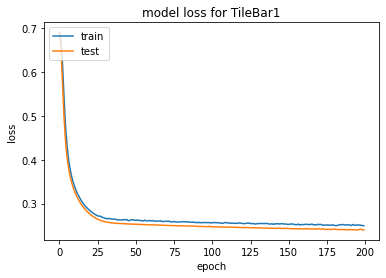

<Figure size 432x288 with 0 Axes>

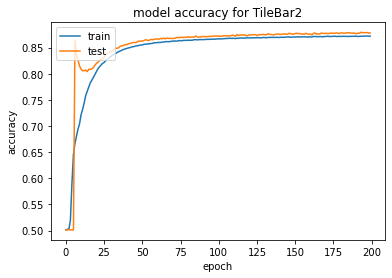

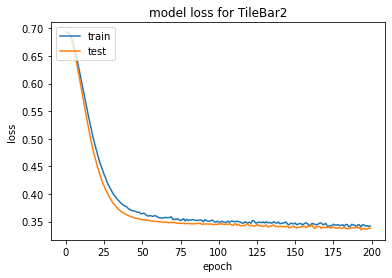

In [21]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_flat[layer_i].history['acc'])
    plt.plot(history_flat[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_flat[layer_i].history['loss'])
    plt.plot(history_flat[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
    plt.show()

In [22]:
from sklearn.metrics import roc_curve, auc

In [23]:
# roc curves, for all layers


y_flat_pred = {}
fpr_flat_nn = {} 
tpr_flat_nn = {} 
thres_flat_nn = {}
auc_flat_nn = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
    fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1],drop_intermediate=False)
    auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
    print("Area under curve: {}".format(auc_flat_nn[layer_i]))

Area under curve: 0.9915151060984394
Area under curve: 0.992245766551322
Area under curve: 0.98504088434644
Area under curve: 0.91747047997048
Area under curve: 0.9325617971451305
Area under curve: 0.8884770794493015


In [24]:
x_lc = np.append(1-p0['cluster_EM_PROBABILITY'],1 - pp['cluster_EM_PROBABILITY'])
y_lc = np.append(p0['label'], pp['label']) 

In [25]:
fpr_lc, tpr_lc, thresh_lc = roc_curve(y_lc, x_lc)
auc_lc = auc(fpr_lc, tpr_lc)
print("Area under curve: {}".format(auc_lc))

Area under curve: 0.9787681202060897


<Figure size 432x288 with 0 Axes>

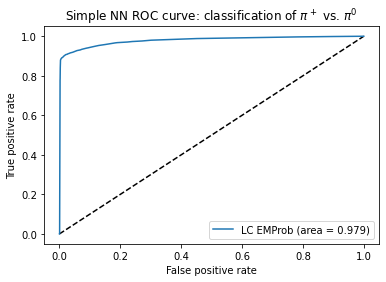

In [26]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

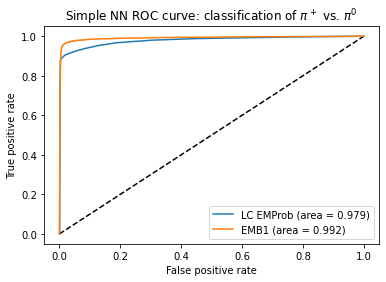

In [27]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_flat_nn[0], tpr_flat_nn[0], label='{} (area = {:.3f})'.format('EMB1', auc_flat_nn[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_emb1_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

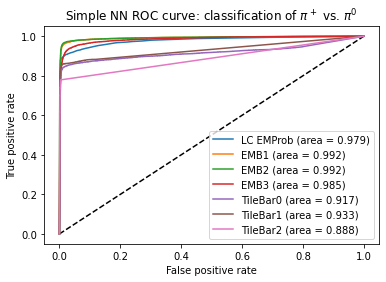

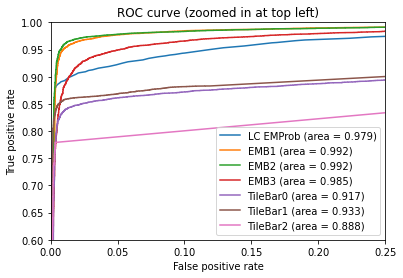

In [28]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_layers.pdf')
plt.show()


In [29]:
y_flat_pred_stack = np.column_stack((y_flat_pred[0][:,1], y_flat_pred[1][:,1],y_flat_pred[2][:,1],y_flat_pred[3][:,1],y_flat_pred[4][:,1],y_flat_pred[5][:,1]))

y_flat_pred_vl = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred_vl[layer_i] = models_flat[layer_i].predict(x_flat_vl[layer_i])
#     print len(y_flat_pred_vl[layer_i])

y_flat_pred_vl_stack = np.column_stack((y_flat_pred_vl[0][:,1], y_flat_pred_vl[1][:,1],y_flat_pred_vl[2][:,1],y_flat_pred_vl[3][:,1],y_flat_pred_vl[4][:,1],y_flat_pred_vl[5][:,1]))

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model_simpleCombine = Sequential()
model_simpleCombine.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_simpleCombine.add(Dense(4, activation='relu'))
model_simpleCombine.add(Dense(2, kernel_initializer='normal', activation='softmax'))
model_simpleCombine.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
history_simpleCombine = model_simpleCombine.fit(y_flat_pred_stack, y_flat_te_onehot[0], epochs = 200, batch_size = 200*ngpu, verbose = 2)

Epoch 1/200
120/120 - 0s - loss: 0.6329 - acc: 0.7639
Epoch 2/200
120/120 - 0s - loss: 0.3603 - acc: 0.9671
Epoch 3/200
120/120 - 0s - loss: 0.2423 - acc: 0.9814
Epoch 4/200
120/120 - 0s - loss: 0.1971 - acc: 0.9857
Epoch 5/200
120/120 - 0s - loss: 0.1679 - acc: 0.9864
Epoch 6/200
120/120 - 0s - loss: 0.1469 - acc: 0.9866
Epoch 7/200
120/120 - 0s - loss: 0.1309 - acc: 0.9865
Epoch 8/200
120/120 - 0s - loss: 0.1185 - acc: 0.9865
Epoch 9/200
120/120 - 0s - loss: 0.1085 - acc: 0.9866
Epoch 10/200
120/120 - 0s - loss: 0.1005 - acc: 0.9866
Epoch 11/200
120/120 - 0s - loss: 0.0939 - acc: 0.9867
Epoch 12/200
120/120 - 0s - loss: 0.0884 - acc: 0.9867
Epoch 13/200
120/120 - 0s - loss: 0.0838 - acc: 0.9866
Epoch 14/200
120/120 - 0s - loss: 0.0799 - acc: 0.9864
Epoch 15/200
120/120 - 0s - loss: 0.0766 - acc: 0.9865
Epoch 16/200
120/120 - 0s - loss: 0.0737 - acc: 0.9864
Epoch 17/200
120/120 - 0s - loss: 0.0712 - acc: 0.9868
Epoch 18/200
120/120 - 0s - loss: 0.0691 - acc: 0.9866
Epoch 19/200
120/12

120/120 - 0s - loss: 0.0487 - acc: 0.9875
Epoch 150/200
120/120 - 0s - loss: 0.0486 - acc: 0.9875
Epoch 151/200
120/120 - 0s - loss: 0.0486 - acc: 0.9874
Epoch 152/200
120/120 - 0s - loss: 0.0486 - acc: 0.9872
Epoch 153/200
120/120 - 0s - loss: 0.0485 - acc: 0.9875
Epoch 154/200
120/120 - 0s - loss: 0.0486 - acc: 0.9874
Epoch 155/200
120/120 - 0s - loss: 0.0485 - acc: 0.9874
Epoch 156/200
120/120 - 0s - loss: 0.0485 - acc: 0.9875
Epoch 157/200
120/120 - 0s - loss: 0.0486 - acc: 0.9875
Epoch 158/200
120/120 - 0s - loss: 0.0486 - acc: 0.9873
Epoch 159/200
120/120 - 0s - loss: 0.0485 - acc: 0.9874
Epoch 160/200
120/120 - 0s - loss: 0.0486 - acc: 0.9873
Epoch 161/200
120/120 - 0s - loss: 0.0486 - acc: 0.9874
Epoch 162/200
120/120 - 0s - loss: 0.0485 - acc: 0.9875
Epoch 163/200
120/120 - 0s - loss: 0.0486 - acc: 0.9872
Epoch 164/200
120/120 - 0s - loss: 0.0486 - acc: 0.9873
Epoch 165/200
120/120 - 0s - loss: 0.0485 - acc: 0.9874
Epoch 166/200
120/120 - 0s - loss: 0.0485 - acc: 0.9876
Epoch 

<Figure size 432x288 with 0 Axes>

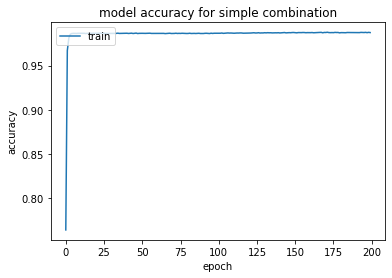

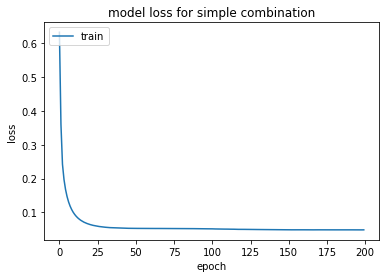

In [31]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_simpleCombine.history['acc'])
#     plt.plot(history_simpleCombine.history['val_acc'])
    plt.title('model accuracy for simple combination')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'accuracy_simpleCombine.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_simpleCombine.history['loss'])
#     plt.plot(history_simpleCombine.history['val_loss'])
    plt.title('model loss for simple combination')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'loss_simpleCombine.pdf')
    plt.show()
    

In [32]:
combined_pred = model_simpleCombine.predict(y_flat_pred_vl_stack)
fpr_simpleCombine, tpr_simpleCombine, thres_simpleCombine = roc_curve(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
auc_combined  = auc(fpr_simpleCombine, tpr_simpleCombine)
print(auc_combined)

0.9970304593491071


<Figure size 432x288 with 0 Axes>

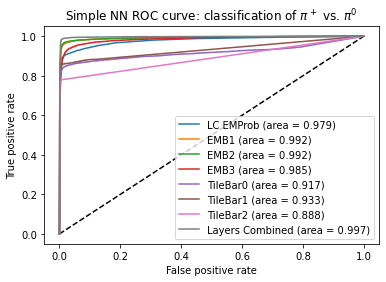

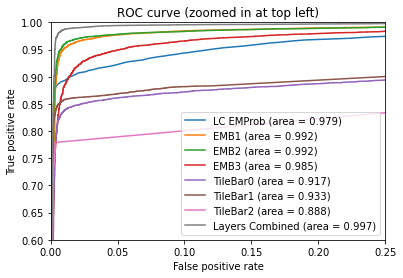

In [33]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_combine1_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_zoom_combine1_layers.pdf')
plt.show()


In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [38]:
with strategy.scope():    

    model_combine = Sequential()

    #EMB1
    input1 = Input(shape=(512,), name = 'input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(256, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)

    #EMB2
    input2 = Input(shape=(256,), name = 'input2')
    x2 = Dense(256, activation='relu')(input2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(64, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)

    #EMB3
    input3 = Input(shape=(128,), name = 'input3')
    x3 = Dense(128, activation='relu')(input3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(64, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(32, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)

    #Tile0
    input4 = Input(shape=(16,), name = 'input4')
    x4 = Dense(16, activation='relu')(input4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(8, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(4, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)

    #Tile1
    input5 = Input(shape=(16,), name = 'input5')
    x5 = Dense(16, activation='relu')(input5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(8, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(4, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)

    #Tile2
    input6 = Input(shape=(8,), name = 'input6')
    x6 = Dense(8, activation='relu')(input6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(4, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(2, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)

    #Combination
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)

    output_combine = Dense(2, activation='softmax')(x)

    model_combine = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output_combine])
    model_combine.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['acc'])   

In [39]:
# history_combine = model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], [y_flat_tr_onehot[0]], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], [y_flat_vl_onehot[0]]), epochs=200, batch_size=200*ngpu, verbose=2)

# removed [] around the y for train and valid to make it work
history_combine = model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], y_flat_tr_onehot[0], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], y_flat_vl_onehot[0]), epochs=200, batch_size=200*ngpu, verbose=2)

Epoch 1/200
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:ten

Epoch 75/200
579/579 - 4s - acc: 0.9879 - loss: 0.0488 - val_acc: 0.9883 - val_loss: 0.0443
Epoch 76/200
579/579 - 4s - acc: 0.9880 - loss: 0.0485 - val_acc: 0.9883 - val_loss: 0.0457
Epoch 77/200
579/579 - 4s - acc: 0.9883 - loss: 0.0481 - val_acc: 0.9887 - val_loss: 0.0442
Epoch 78/200
579/579 - 4s - acc: 0.9880 - loss: 0.0479 - val_acc: 0.9881 - val_loss: 0.0455
Epoch 79/200
579/579 - 4s - acc: 0.9884 - loss: 0.0468 - val_acc: 0.9884 - val_loss: 0.0445
Epoch 80/200
579/579 - 4s - acc: 0.9882 - loss: 0.0476 - val_acc: 0.9873 - val_loss: 0.0508
Epoch 81/200
579/579 - 4s - acc: 0.9880 - loss: 0.0479 - val_acc: 0.9878 - val_loss: 0.0474
Epoch 82/200
579/579 - 4s - acc: 0.9884 - loss: 0.0468 - val_acc: 0.9886 - val_loss: 0.0455
Epoch 83/200
579/579 - 4s - acc: 0.9884 - loss: 0.0471 - val_acc: 0.9886 - val_loss: 0.0449
Epoch 84/200
579/579 - 4s - acc: 0.9882 - loss: 0.0471 - val_acc: 0.9887 - val_loss: 0.0438
Epoch 85/200
579/579 - 4s - acc: 0.9884 - loss: 0.0468 - val_acc: 0.9888 - val_l

Epoch 164/200
579/579 - 4s - acc: 0.9899 - loss: 0.0404 - val_acc: 0.9895 - val_loss: 0.0423
Epoch 165/200
579/579 - 4s - acc: 0.9897 - loss: 0.0406 - val_acc: 0.9898 - val_loss: 0.0410
Epoch 166/200
579/579 - 4s - acc: 0.9899 - loss: 0.0402 - val_acc: 0.9896 - val_loss: 0.0423
Epoch 167/200
579/579 - 4s - acc: 0.9898 - loss: 0.0401 - val_acc: 0.9896 - val_loss: 0.0412
Epoch 168/200
579/579 - 4s - acc: 0.9898 - loss: 0.0403 - val_acc: 0.9900 - val_loss: 0.0416
Epoch 169/200
579/579 - 4s - acc: 0.9900 - loss: 0.0401 - val_acc: 0.9897 - val_loss: 0.0404
Epoch 170/200
579/579 - 4s - acc: 0.9900 - loss: 0.0401 - val_acc: 0.9897 - val_loss: 0.0417
Epoch 171/200
579/579 - 4s - acc: 0.9900 - loss: 0.0391 - val_acc: 0.9892 - val_loss: 0.0416
Epoch 172/200
579/579 - 4s - acc: 0.9898 - loss: 0.0398 - val_acc: 0.9896 - val_loss: 0.0422
Epoch 173/200
579/579 - 4s - acc: 0.9899 - loss: 0.0396 - val_acc: 0.9897 - val_loss: 0.0410
Epoch 174/200
579/579 - 4s - acc: 0.9897 - loss: 0.0403 - val_acc: 0.9

In [40]:
model_combine.save(modelpath+"model_deep_do20.h5")

In [41]:
model_combine = tf.keras.models.load_model(modelpath+"model_deep_do20.h5")

<Figure size 432x288 with 0 Axes>

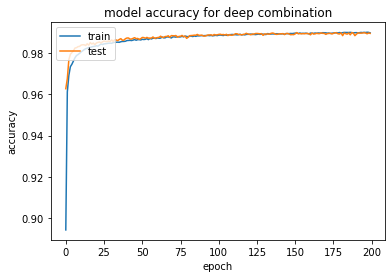

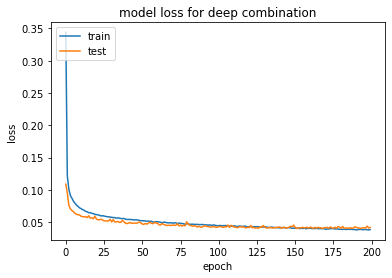

In [42]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_combine.history['acc'])
plt.plot(history_combine.history['val_acc'])
plt.title('model accuracy for deep combination')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/accuracy_deepCombine.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_combine.history['loss'])
plt.plot(history_combine.history['val_loss'])
plt.title('model loss for deep combination')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/loss_deepCombine.pdf')
plt.show()


In [43]:
y_combine_pred = model_combine.predict([x_flat_te[0], x_flat_te[1], x_flat_te[2], x_flat_te[3], x_flat_te[4], x_flat_te[5]])
fpr_combine, tpr_combine, thres_combine = roc_curve(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])
auc_combine = auc(fpr_combine, tpr_combine)
print("Area under curve: {}".format(auc_combine))

Area under curve: 0.9964548020103575


<Figure size 432x288 with 0 Axes>

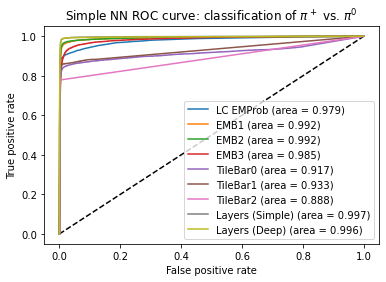

<Figure size 432x288 with 0 Axes>

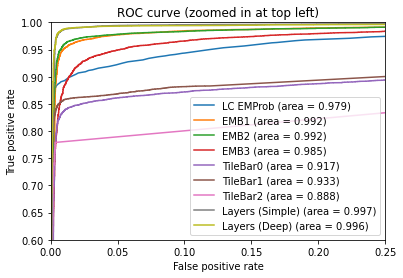

In [44]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_layers.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_layers.pdf')
plt.show()


<ipython-input-45-ceb9d176c8ca>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_lc, 1/fpr_lc, label='LC EMProb')
<ipython-input-45-ceb9d176c8ca>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
<ipython-input-45-ceb9d176c8ca>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
<ipython-input-45-ceb9d176c8ca>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
<ipython-input-45-ceb9d176c8ca>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
<ipython-input-45-ceb9d176c8ca>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_flat_nn[layer_i], 1/fpr_fla

<Figure size 432x288 with 0 Axes>

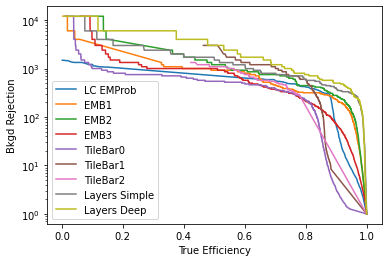

In [45]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.yscale('log')
plt.plot(tpr_lc, 1/fpr_lc, label='LC EMProb')
for layer_i, layer_name in enumerate(layers):
    plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
plt.plot(tpr_simpleCombine, 1/fpr_simpleCombine, label='Layers Simple')
plt.plot(tpr_combine, 1/fpr_combine, label='Layers Deep')
plt.legend(loc='best')
plt.xlabel('True Efficiency')
plt.ylabel('Bkgd Rejection')
plt.savefig(plotpath+'roc_reg_combine2_layers.pdf')
plt.show()


In [46]:
#function to split apart a prediction list according to the one hot values.
#really, could have done this by evaluating the nn with a non-concatted nparray, but we already have this handy
def split_pred(onehot, pred):
    list_one = [element_n for element_n, element in enumerate(onehot) if element==1]
    one_vals = [element for element_n, element in enumerate(pred) if element_n in list_one]
    zer_vals = [element for element_n, element in enumerate(pred) if element_n not in list_one]
    
    return one_vals, zer_vals

<Figure size 432x288 with 0 Axes>

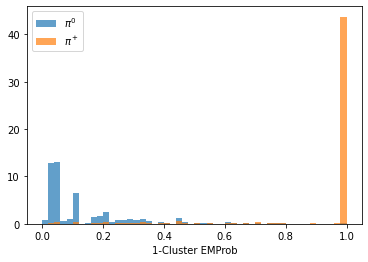

<Figure size 432x288 with 0 Axes>

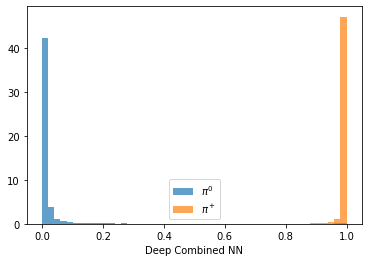

<Figure size 432x288 with 0 Axes>

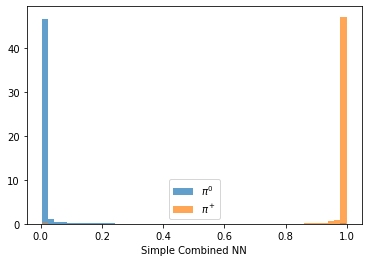

<Figure size 432x288 with 0 Axes>

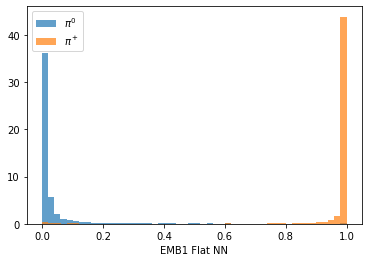

<Figure size 432x288 with 0 Axes>

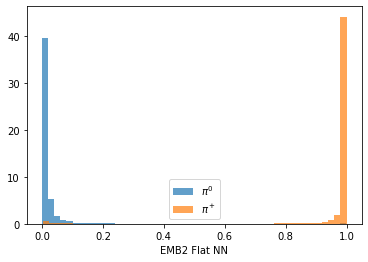

<Figure size 432x288 with 0 Axes>

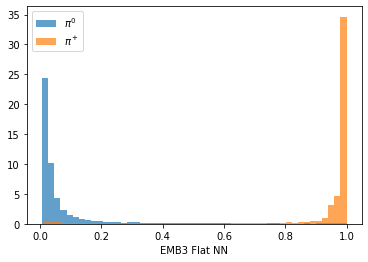

<Figure size 432x288 with 0 Axes>

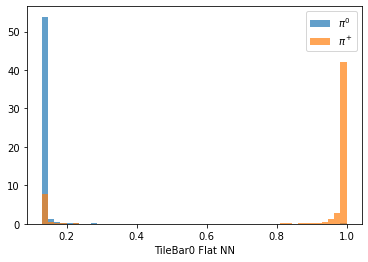

<Figure size 432x288 with 0 Axes>

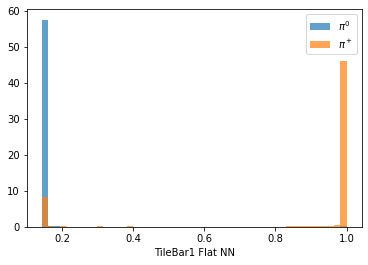

<Figure size 432x288 with 0 Axes>

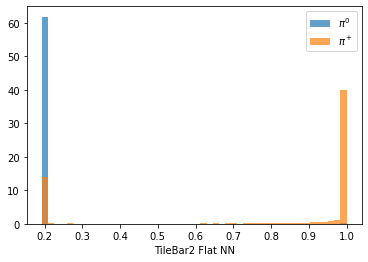

In [48]:
n_bins = 50
#time for histogramming
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(1-p0['cluster_EM_PROBABILITY'], bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
plt.hist(1-pp['cluster_EM_PROBABILITY'], bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('1-Cluster EMProb')
plt.legend()
plt.savefig('Plots/hist_emprob.pdf')
plt.show()

pip_vals_combine, p0_vals_combine = split_pred(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_combine, bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_combine, bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Deep Combined NN')
plt.legend()
plt.savefig('Plots/hist_deep.pdf')
plt.show()

pip_vals_simpleCombine, p0_vals_simpleCombine = split_pred(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_simpleCombine, bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_simpleCombine, bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Simple Combined NN')
plt.legend()
plt.savefig('Plots/hist_simple.pdf')
plt.show()

pip_vals_flat = {}
p0_vals_flat = {}
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    pip_vals_flat[layer_i], p0_vals_flat[layer_i] = split_pred(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(p0_vals_flat[layer_i], bins=n_bins, density=True, alpha=0.7, label='$\pi^0$')
    plt.hist(pip_vals_flat[layer_i], bins=n_bins, density=True, alpha=0.7, label='$\pi^+$')
    plt.xlabel('{} Flat NN'.format(layer_name))
    plt.legend()
    plt.savefig('Plots/hist_flatnn_{}.pdf'.format(layer_name))
    plt.show()

## 2. Convolutional Neural Network

In [49]:
def format_cnn(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])
    X = np.append(data_0[layer], data_1[layer], axis=0)
    X = X.reshape(X.shape[0], 1, len_phi[selected_layer], len_eta[selected_layer])
    
    Y = np.append(data_0['label'], data_1['label'], axis=0)
    return X, Y, num_pixels

In [50]:

#old, one by one method
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# mswiatlo-- let's do this with the pi+/pi0 samples!

# include the EMB2 layer as a 2D image
selected_layer = 1
layer = layers[selected_layer]
num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

# X = np.append(elec[layer], pion[layer], axis=0)
X = np.append(pp[layer], p0[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

# y = np.append(elec['label'], pion['label'], axis=0)
y = np.append(pp['label'], p0['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(158653, 1, 16, 16)
(158653, 1)
y_train.shape:  (158653, 1)
y_train_onehot.shape:  (158653, 2)


In [51]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import backend as K
# K.image_data_format('th')
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

x_cnn = {}
y_cnn = {}
num_pixels_cnn = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn[layer_i], y_cnn[layer_i], num_pixels_cnn[layer_i] = format_cnn(p0, pp, layer_i)

In [52]:
# split up into training and test datasets, using functions
test_size = 24000
validation_size = 24000

x_cnn_tr = {}
x_cnn_te = {}
x_cnn_vl = {}
y_cnn_tr_onehot = {}
y_cnn_te_onehot = {}
y_cnn_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn_tr[layer_i], x_cnn_te[layer_i], x_cnn_vl[layer_i], y_cnn_tr_onehot[layer_i], y_cnn_te_onehot[layer_i], y_cnn_vl_onehot[layer_i] = make_split_samples(x_cnn[layer_i], y_cnn[layer_i], test_size, validation_size)


y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)
y_train.shape:  (115653, 1)
y_train_onehot.shape:  (115653, 2)


In [53]:
# define a simple convolutional model
def baseline_ccn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [54]:
# define a simple convolutional model

filters = [(2,4), (4,4), (4,4), (2,2), (2,2), (2,1)]

def baseline_cnn_model_layers(layer_i):
    # create model
#     with strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, filters[layer_i], input_shape=(1,len_phi[layer_i],len_eta[layer_i]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [55]:
model_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print(layer_name)
    print(len_phi[layer_i])
    print(len_eta[layer_i])
    model_cnn_base_layers[layer_i] = baseline_cnn_model_layers(layer_i)
    model_cnn_base_layers[layer_i].summary()

EMB1
4
128
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 3, 125)        288       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 1, 62)         0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 32, 1, 62)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1984)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 128)               254080    
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 258       
Total params: 254,626
Trainable params: 254,626
Non-trainable params: 0
_____________________________________

In [56]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [57]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 13, 13)        544       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 6, 6)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 5, 5)          2064      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 2, 2)          0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 16, 2, 2)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 128)             

In [58]:
history_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer {}'.format(layer_name))
    history_cnn_base_layers[layer_i] = model_cnn_base_layers[layer_i].fit(x_cnn_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(x_cnn_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=200, batch_size=200*ngpu, verbose=2)


On layer EMB1
Epoch 1/200
579/579 - 1s - loss: 0.4046 - acc: 0.8262 - val_loss: 0.3418 - val_acc: 0.8543
Epoch 2/200
579/579 - 2s - loss: 0.3399 - acc: 0.8583 - val_loss: 0.2982 - val_acc: 0.8747
Epoch 3/200
579/579 - 2s - loss: 0.2593 - acc: 0.8977 - val_loss: 0.2421 - val_acc: 0.9075
Epoch 4/200
579/579 - 2s - loss: 0.1941 - acc: 0.9281 - val_loss: 0.1708 - val_acc: 0.9475
Epoch 5/200
579/579 - 2s - loss: 0.1719 - acc: 0.9383 - val_loss: 0.1487 - val_acc: 0.9519
Epoch 6/200
579/579 - 2s - loss: 0.1580 - acc: 0.9442 - val_loss: 0.1667 - val_acc: 0.9422
Epoch 7/200
579/579 - 2s - loss: 0.1497 - acc: 0.9471 - val_loss: 0.1363 - val_acc: 0.9509
Epoch 8/200
579/579 - 2s - loss: 0.1449 - acc: 0.9489 - val_loss: 0.1764 - val_acc: 0.9300
Epoch 9/200
579/579 - 2s - loss: 0.1417 - acc: 0.9508 - val_loss: 0.1241 - val_acc: 0.9592
Epoch 10/200
579/579 - 2s - loss: 0.1358 - acc: 0.9535 - val_loss: 0.1509 - val_acc: 0.9440
Epoch 11/200
579/579 - 2s - loss: 0.1352 - acc: 0.9534 - val_loss: 0.1214 -

Epoch 90/200
579/579 - 2s - loss: 0.0974 - acc: 0.9684 - val_loss: 0.0956 - val_acc: 0.9684
Epoch 91/200
579/579 - 2s - loss: 0.0979 - acc: 0.9677 - val_loss: 0.1015 - val_acc: 0.9655
Epoch 92/200
579/579 - 2s - loss: 0.0991 - acc: 0.9674 - val_loss: 0.1045 - val_acc: 0.9658
Epoch 93/200
579/579 - 2s - loss: 0.0967 - acc: 0.9690 - val_loss: 0.0911 - val_acc: 0.9712
Epoch 94/200
579/579 - 2s - loss: 0.0975 - acc: 0.9682 - val_loss: 0.1007 - val_acc: 0.9667
Epoch 95/200
579/579 - 2s - loss: 0.0987 - acc: 0.9682 - val_loss: 0.1004 - val_acc: 0.9667
Epoch 96/200
579/579 - 1s - loss: 0.0953 - acc: 0.9693 - val_loss: 0.0976 - val_acc: 0.9686
Epoch 97/200
579/579 - 2s - loss: 0.0972 - acc: 0.9689 - val_loss: 0.0917 - val_acc: 0.9722
Epoch 98/200
579/579 - 2s - loss: 0.0968 - acc: 0.9686 - val_loss: 0.1151 - val_acc: 0.9575
Epoch 99/200
579/579 - 2s - loss: 0.0986 - acc: 0.9679 - val_loss: 0.0963 - val_acc: 0.9690
Epoch 100/200
579/579 - 2s - loss: 0.0955 - acc: 0.9692 - val_loss: 0.1054 - val

Epoch 179/200
579/579 - 2s - loss: 0.0865 - acc: 0.9730 - val_loss: 0.0845 - val_acc: 0.9753
Epoch 180/200
579/579 - 2s - loss: 0.0861 - acc: 0.9730 - val_loss: 0.0888 - val_acc: 0.9737
Epoch 181/200
579/579 - 2s - loss: 0.0858 - acc: 0.9735 - val_loss: 0.0856 - val_acc: 0.9750
Epoch 182/200
579/579 - 2s - loss: 0.0863 - acc: 0.9731 - val_loss: 0.0851 - val_acc: 0.9748
Epoch 183/200
579/579 - 2s - loss: 0.0862 - acc: 0.9732 - val_loss: 0.0861 - val_acc: 0.9745
Epoch 184/200
579/579 - 1s - loss: 0.0873 - acc: 0.9729 - val_loss: 0.1074 - val_acc: 0.9649
Epoch 185/200
579/579 - 1s - loss: 0.0855 - acc: 0.9736 - val_loss: 0.0920 - val_acc: 0.9722
Epoch 186/200
579/579 - 1s - loss: 0.0851 - acc: 0.9735 - val_loss: 0.0911 - val_acc: 0.9729
Epoch 187/200
579/579 - 1s - loss: 0.0858 - acc: 0.9736 - val_loss: 0.0842 - val_acc: 0.9752
Epoch 188/200
579/579 - 1s - loss: 0.0863 - acc: 0.9730 - val_loss: 0.0877 - val_acc: 0.9745
Epoch 189/200
579/579 - 1s - loss: 0.0860 - acc: 0.9728 - val_loss: 0.

Epoch 68/200
579/579 - 2s - loss: 0.1000 - acc: 0.9710 - val_loss: 0.0874 - val_acc: 0.9757
Epoch 69/200
579/579 - 1s - loss: 0.0990 - acc: 0.9714 - val_loss: 0.0873 - val_acc: 0.9762
Epoch 70/200
579/579 - 1s - loss: 0.1001 - acc: 0.9709 - val_loss: 0.0911 - val_acc: 0.9735
Epoch 71/200
579/579 - 1s - loss: 0.0987 - acc: 0.9715 - val_loss: 0.0903 - val_acc: 0.9722
Epoch 72/200
579/579 - 1s - loss: 0.0963 - acc: 0.9725 - val_loss: 0.0893 - val_acc: 0.9742
Epoch 73/200
579/579 - 1s - loss: 0.0976 - acc: 0.9718 - val_loss: 0.0878 - val_acc: 0.9751
Epoch 74/200
579/579 - 1s - loss: 0.0981 - acc: 0.9718 - val_loss: 0.0887 - val_acc: 0.9737
Epoch 75/200
579/579 - 1s - loss: 0.0958 - acc: 0.9727 - val_loss: 0.0868 - val_acc: 0.9744
Epoch 76/200
579/579 - 1s - loss: 0.0979 - acc: 0.9715 - val_loss: 0.0898 - val_acc: 0.9747
Epoch 77/200
579/579 - 1s - loss: 0.0955 - acc: 0.9726 - val_loss: 0.0854 - val_acc: 0.9774
Epoch 78/200
579/579 - 1s - loss: 0.0972 - acc: 0.9717 - val_loss: 0.0833 - val_

Epoch 157/200
579/579 - 1s - loss: 0.0782 - acc: 0.9774 - val_loss: 0.0687 - val_acc: 0.9802
Epoch 158/200
579/579 - 1s - loss: 0.0783 - acc: 0.9775 - val_loss: 0.0795 - val_acc: 0.9796
Epoch 159/200
579/579 - 1s - loss: 0.0785 - acc: 0.9769 - val_loss: 0.0754 - val_acc: 0.9785
Epoch 160/200
579/579 - 2s - loss: 0.0791 - acc: 0.9769 - val_loss: 0.0757 - val_acc: 0.9791
Epoch 161/200
579/579 - 2s - loss: 0.0773 - acc: 0.9779 - val_loss: 0.0762 - val_acc: 0.9783
Epoch 162/200
579/579 - 1s - loss: 0.0779 - acc: 0.9778 - val_loss: 0.0678 - val_acc: 0.9815
Epoch 163/200
579/579 - 1s - loss: 0.0765 - acc: 0.9784 - val_loss: 0.0727 - val_acc: 0.9791
Epoch 164/200
579/579 - 1s - loss: 0.0788 - acc: 0.9771 - val_loss: 0.0740 - val_acc: 0.9792
Epoch 165/200
579/579 - 2s - loss: 0.0782 - acc: 0.9776 - val_loss: 0.0720 - val_acc: 0.9790
Epoch 166/200
579/579 - 2s - loss: 0.0777 - acc: 0.9778 - val_loss: 0.0816 - val_acc: 0.9768
Epoch 167/200
579/579 - 2s - loss: 0.0773 - acc: 0.9779 - val_loss: 0.

Epoch 46/200
579/579 - 2s - loss: 0.2023 - acc: 0.9274 - val_loss: 0.3742 - val_acc: 0.8446
Epoch 47/200
579/579 - 1s - loss: 0.1983 - acc: 0.9292 - val_loss: 0.1817 - val_acc: 0.9368
Epoch 48/200
579/579 - 1s - loss: 0.1996 - acc: 0.9283 - val_loss: 0.1848 - val_acc: 0.9343
Epoch 49/200
579/579 - 1s - loss: 0.1999 - acc: 0.9279 - val_loss: 0.1909 - val_acc: 0.9312
Epoch 50/200
579/579 - 1s - loss: 0.1971 - acc: 0.9295 - val_loss: 0.1855 - val_acc: 0.9382
Epoch 51/200
579/579 - 2s - loss: 0.1963 - acc: 0.9289 - val_loss: 0.2221 - val_acc: 0.9157
Epoch 52/200
579/579 - 2s - loss: 0.1946 - acc: 0.9297 - val_loss: 0.1789 - val_acc: 0.9355
Epoch 53/200
579/579 - 2s - loss: 0.1941 - acc: 0.9306 - val_loss: 0.1723 - val_acc: 0.9409
Epoch 54/200
579/579 - 2s - loss: 0.1910 - acc: 0.9321 - val_loss: 0.1742 - val_acc: 0.9414
Epoch 55/200
579/579 - 2s - loss: 0.1918 - acc: 0.9310 - val_loss: 0.1818 - val_acc: 0.9409
Epoch 56/200
579/579 - 2s - loss: 0.1884 - acc: 0.9323 - val_loss: 0.1756 - val_

Epoch 135/200
579/579 - 1s - loss: 0.1647 - acc: 0.9410 - val_loss: 0.1623 - val_acc: 0.9470
Epoch 136/200
579/579 - 1s - loss: 0.1656 - acc: 0.9407 - val_loss: 0.1538 - val_acc: 0.9456
Epoch 137/200
579/579 - 2s - loss: 0.1628 - acc: 0.9423 - val_loss: 0.1538 - val_acc: 0.9462
Epoch 138/200
579/579 - 2s - loss: 0.1642 - acc: 0.9415 - val_loss: 0.1548 - val_acc: 0.9453
Epoch 139/200
579/579 - 2s - loss: 0.1642 - acc: 0.9418 - val_loss: 0.1500 - val_acc: 0.9476
Epoch 140/200
579/579 - 2s - loss: 0.1634 - acc: 0.9417 - val_loss: 0.1686 - val_acc: 0.9448
Epoch 141/200
579/579 - 2s - loss: 0.1656 - acc: 0.9413 - val_loss: 0.1593 - val_acc: 0.9431
Epoch 142/200
579/579 - 2s - loss: 0.1659 - acc: 0.9411 - val_loss: 0.1510 - val_acc: 0.9481
Epoch 143/200
579/579 - 2s - loss: 0.1605 - acc: 0.9426 - val_loss: 0.1641 - val_acc: 0.9464
Epoch 144/200
579/579 - 2s - loss: 0.1673 - acc: 0.9402 - val_loss: 0.1507 - val_acc: 0.9470
Epoch 145/200
579/579 - 2s - loss: 0.1622 - acc: 0.9419 - val_loss: 0.

Epoch 24/200
579/579 - 1s - loss: 0.2674 - acc: 0.9033 - val_loss: 0.2672 - val_acc: 0.9030
Epoch 25/200
579/579 - 2s - loss: 0.2676 - acc: 0.9034 - val_loss: 0.2667 - val_acc: 0.9038
Epoch 26/200
579/579 - 2s - loss: 0.2667 - acc: 0.9035 - val_loss: 0.2674 - val_acc: 0.9035
Epoch 27/200
579/579 - 2s - loss: 0.2666 - acc: 0.9037 - val_loss: 0.2664 - val_acc: 0.9040
Epoch 28/200
579/579 - 2s - loss: 0.2667 - acc: 0.9039 - val_loss: 0.2659 - val_acc: 0.9038
Epoch 29/200
579/579 - 2s - loss: 0.2669 - acc: 0.9036 - val_loss: 0.2684 - val_acc: 0.9028
Epoch 30/200
579/579 - 2s - loss: 0.2664 - acc: 0.9039 - val_loss: 0.2662 - val_acc: 0.9040
Epoch 31/200
579/579 - 2s - loss: 0.2667 - acc: 0.9039 - val_loss: 0.2654 - val_acc: 0.9038
Epoch 32/200
579/579 - 2s - loss: 0.2656 - acc: 0.9043 - val_loss: 0.2657 - val_acc: 0.9041
Epoch 33/200
579/579 - 2s - loss: 0.2658 - acc: 0.9044 - val_loss: 0.2670 - val_acc: 0.9042
Epoch 34/200
579/579 - 2s - loss: 0.2655 - acc: 0.9044 - val_loss: 0.2655 - val_

Epoch 113/200
579/579 - 1s - loss: 0.2556 - acc: 0.9094 - val_loss: 0.2570 - val_acc: 0.9087
Epoch 114/200
579/579 - 1s - loss: 0.2556 - acc: 0.9092 - val_loss: 0.2560 - val_acc: 0.9087
Epoch 115/200
579/579 - 1s - loss: 0.2544 - acc: 0.9097 - val_loss: 0.2550 - val_acc: 0.9090
Epoch 116/200
579/579 - 1s - loss: 0.2549 - acc: 0.9093 - val_loss: 0.2544 - val_acc: 0.9084
Epoch 117/200
579/579 - 2s - loss: 0.2542 - acc: 0.9093 - val_loss: 0.2555 - val_acc: 0.9088
Epoch 118/200
579/579 - 1s - loss: 0.2548 - acc: 0.9097 - val_loss: 0.2546 - val_acc: 0.9087
Epoch 119/200
579/579 - 2s - loss: 0.2542 - acc: 0.9099 - val_loss: 0.2566 - val_acc: 0.9078
Epoch 120/200
579/579 - 2s - loss: 0.2536 - acc: 0.9093 - val_loss: 0.2524 - val_acc: 0.9094
Epoch 121/200
579/579 - 2s - loss: 0.2530 - acc: 0.9100 - val_loss: 0.2511 - val_acc: 0.9090
Epoch 122/200
579/579 - 2s - loss: 0.2532 - acc: 0.9096 - val_loss: 0.2547 - val_acc: 0.9091
Epoch 123/200
579/579 - 2s - loss: 0.2529 - acc: 0.9099 - val_loss: 0.

579/579 - 1s - loss: 0.3438 - acc: 0.8764 - val_loss: 0.2631 - val_acc: 0.9078
Epoch 2/200
579/579 - 1s - loss: 0.2684 - acc: 0.9067 - val_loss: 0.2586 - val_acc: 0.9097
Epoch 3/200
579/579 - 2s - loss: 0.2644 - acc: 0.9076 - val_loss: 0.2545 - val_acc: 0.9107
Epoch 4/200
579/579 - 2s - loss: 0.2578 - acc: 0.9093 - val_loss: 0.2478 - val_acc: 0.9137
Epoch 5/200
579/579 - 1s - loss: 0.2540 - acc: 0.9109 - val_loss: 0.2451 - val_acc: 0.9149
Epoch 6/200
579/579 - 2s - loss: 0.2527 - acc: 0.9120 - val_loss: 0.2464 - val_acc: 0.9149
Epoch 7/200
579/579 - 2s - loss: 0.2518 - acc: 0.9122 - val_loss: 0.2445 - val_acc: 0.9158
Epoch 8/200
579/579 - 2s - loss: 0.2508 - acc: 0.9129 - val_loss: 0.2442 - val_acc: 0.9171
Epoch 9/200
579/579 - 1s - loss: 0.2502 - acc: 0.9134 - val_loss: 0.2435 - val_acc: 0.9173
Epoch 10/200
579/579 - 1s - loss: 0.2494 - acc: 0.9138 - val_loss: 0.2426 - val_acc: 0.9176
Epoch 11/200
579/579 - 1s - loss: 0.2490 - acc: 0.9140 - val_loss: 0.2417 - val_acc: 0.9176
Epoch 12/

Epoch 91/200
579/579 - 1s - loss: 0.2434 - acc: 0.9172 - val_loss: 0.2359 - val_acc: 0.9205
Epoch 92/200
579/579 - 1s - loss: 0.2435 - acc: 0.9172 - val_loss: 0.2381 - val_acc: 0.9203
Epoch 93/200
579/579 - 1s - loss: 0.2438 - acc: 0.9170 - val_loss: 0.2359 - val_acc: 0.9208
Epoch 94/200
579/579 - 1s - loss: 0.2429 - acc: 0.9171 - val_loss: 0.2372 - val_acc: 0.9211
Epoch 95/200
579/579 - 1s - loss: 0.2437 - acc: 0.9172 - val_loss: 0.2405 - val_acc: 0.9209
Epoch 96/200
579/579 - 1s - loss: 0.2429 - acc: 0.9173 - val_loss: 0.2364 - val_acc: 0.9205
Epoch 97/200
579/579 - 1s - loss: 0.2436 - acc: 0.9171 - val_loss: 0.2358 - val_acc: 0.9205
Epoch 98/200
579/579 - 1s - loss: 0.2434 - acc: 0.9173 - val_loss: 0.2349 - val_acc: 0.9205
Epoch 99/200
579/579 - 1s - loss: 0.2434 - acc: 0.9172 - val_loss: 0.2363 - val_acc: 0.9201
Epoch 100/200
579/579 - 1s - loss: 0.2425 - acc: 0.9173 - val_loss: 0.2347 - val_acc: 0.9210
Epoch 101/200
579/579 - 1s - loss: 0.2426 - acc: 0.9174 - val_loss: 0.2351 - va

Epoch 180/200
579/579 - 1s - loss: 0.2408 - acc: 0.9172 - val_loss: 0.2328 - val_acc: 0.9207
Epoch 181/200
579/579 - 1s - loss: 0.2407 - acc: 0.9174 - val_loss: 0.2327 - val_acc: 0.9207
Epoch 182/200
579/579 - 1s - loss: 0.2404 - acc: 0.9174 - val_loss: 0.2316 - val_acc: 0.9207
Epoch 183/200
579/579 - 1s - loss: 0.2411 - acc: 0.9173 - val_loss: 0.2335 - val_acc: 0.9206
Epoch 184/200
579/579 - 1s - loss: 0.2414 - acc: 0.9173 - val_loss: 0.2367 - val_acc: 0.9202
Epoch 185/200
579/579 - 1s - loss: 0.2409 - acc: 0.9172 - val_loss: 0.2359 - val_acc: 0.9209
Epoch 186/200
579/579 - 1s - loss: 0.2415 - acc: 0.9172 - val_loss: 0.2355 - val_acc: 0.9206
Epoch 187/200
579/579 - 2s - loss: 0.2410 - acc: 0.9174 - val_loss: 0.2329 - val_acc: 0.9205
Epoch 188/200
579/579 - 2s - loss: 0.2411 - acc: 0.9174 - val_loss: 0.2335 - val_acc: 0.9206
Epoch 189/200
579/579 - 2s - loss: 0.2409 - acc: 0.9173 - val_loss: 0.2323 - val_acc: 0.9206
Epoch 190/200
579/579 - 2s - loss: 0.2407 - acc: 0.9171 - val_loss: 0.

Epoch 69/200
579/579 - 2s - loss: 0.3328 - acc: 0.8680 - val_loss: 0.3436 - val_acc: 0.8772
Epoch 70/200
579/579 - 2s - loss: 0.3314 - acc: 0.8680 - val_loss: 0.3330 - val_acc: 0.8684
Epoch 71/200
579/579 - 2s - loss: 0.3307 - acc: 0.8693 - val_loss: 0.3376 - val_acc: 0.8649
Epoch 72/200
579/579 - 2s - loss: 0.3286 - acc: 0.8699 - val_loss: 0.3259 - val_acc: 0.8718
Epoch 73/200
579/579 - 2s - loss: 0.3287 - acc: 0.8700 - val_loss: 0.3224 - val_acc: 0.8736
Epoch 74/200
579/579 - 2s - loss: 0.3284 - acc: 0.8697 - val_loss: 0.3288 - val_acc: 0.8757
Epoch 75/200
579/579 - 1s - loss: 0.3271 - acc: 0.8708 - val_loss: 0.3295 - val_acc: 0.8724
Epoch 76/200
579/579 - 1s - loss: 0.3293 - acc: 0.8695 - val_loss: 0.3355 - val_acc: 0.8714
Epoch 77/200
579/579 - 1s - loss: 0.3279 - acc: 0.8700 - val_loss: 0.3272 - val_acc: 0.8704
Epoch 78/200
579/579 - 1s - loss: 0.3298 - acc: 0.8693 - val_loss: 0.3241 - val_acc: 0.8736
Epoch 79/200
579/579 - 2s - loss: 0.3273 - acc: 0.8706 - val_loss: 0.3338 - val_

Epoch 158/200
579/579 - 2s - loss: 0.3233 - acc: 0.8735 - val_loss: 0.3267 - val_acc: 0.8758
Epoch 159/200
579/579 - 2s - loss: 0.3234 - acc: 0.8733 - val_loss: 0.3193 - val_acc: 0.8772
Epoch 160/200
579/579 - 2s - loss: 0.3246 - acc: 0.8730 - val_loss: 0.3270 - val_acc: 0.8751
Epoch 161/200
579/579 - 2s - loss: 0.3218 - acc: 0.8746 - val_loss: 0.3170 - val_acc: 0.8792
Epoch 162/200
579/579 - 1s - loss: 0.3229 - acc: 0.8740 - val_loss: 0.3237 - val_acc: 0.8772
Epoch 163/200
579/579 - 1s - loss: 0.3231 - acc: 0.8742 - val_loss: 0.3269 - val_acc: 0.8752
Epoch 164/200
579/579 - 2s - loss: 0.3258 - acc: 0.8719 - val_loss: 0.3252 - val_acc: 0.8770
Epoch 165/200
579/579 - 2s - loss: 0.3238 - acc: 0.8735 - val_loss: 0.3241 - val_acc: 0.8744
Epoch 166/200
579/579 - 1s - loss: 0.3227 - acc: 0.8740 - val_loss: 0.3231 - val_acc: 0.8770
Epoch 167/200
579/579 - 1s - loss: 0.3220 - acc: 0.8742 - val_loss: 0.3212 - val_acc: 0.8774
Epoch 168/200
579/579 - 1s - loss: 0.3237 - acc: 0.8736 - val_loss: 0.

<Figure size 432x288 with 0 Axes>

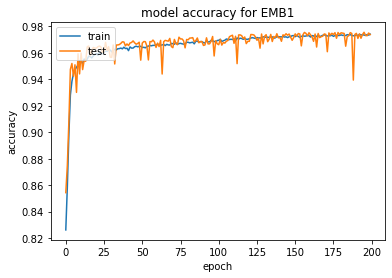

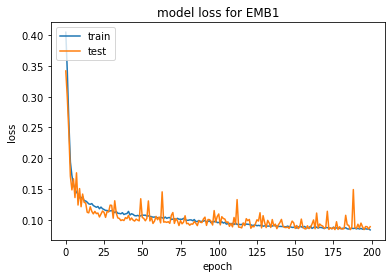

<Figure size 432x288 with 0 Axes>

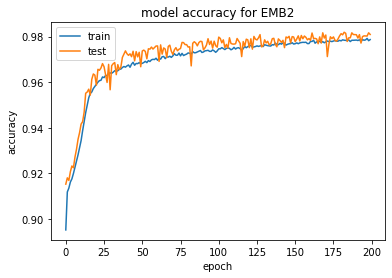

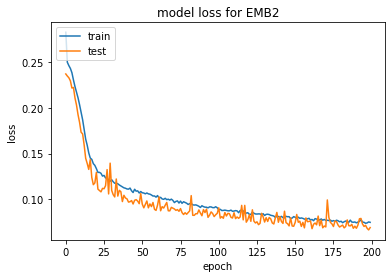

<Figure size 432x288 with 0 Axes>

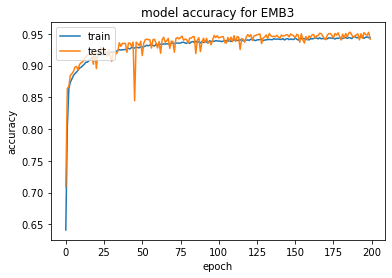

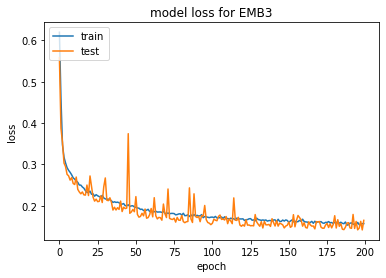

<Figure size 432x288 with 0 Axes>

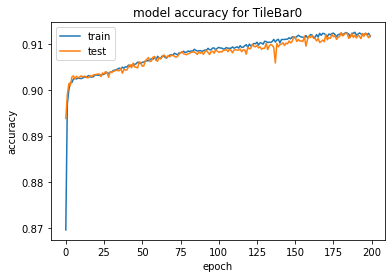

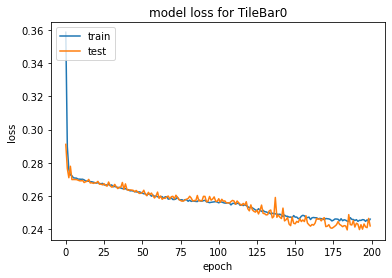

<Figure size 432x288 with 0 Axes>

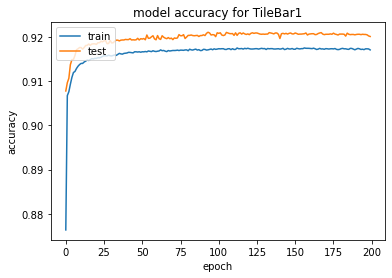

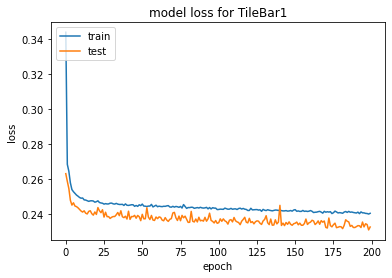

<Figure size 432x288 with 0 Axes>

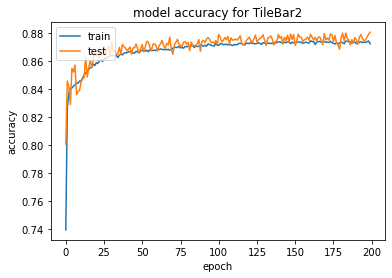

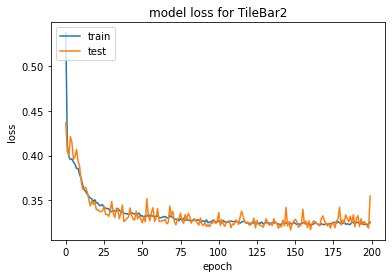

In [59]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_base_layers[layer_i].history['acc'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_cnn_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_base_layers[layer_i].history['loss'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_cnn_{}.pdf'.format(layer_name))
    plt.show()

In [60]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=40, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

Epoch 1/40
794/794 - 2s - loss: 0.2720 - acc: 0.9013 - val_loss: 0.2300 - val_acc: 0.9140
Epoch 2/40
794/794 - 2s - loss: 0.2239 - acc: 0.9208 - val_loss: 0.2004 - val_acc: 0.9340
Epoch 3/40
794/794 - 2s - loss: 0.2027 - acc: 0.9308 - val_loss: 0.1708 - val_acc: 0.9460
Epoch 4/40
794/794 - 2s - loss: 0.1819 - acc: 0.9403 - val_loss: 0.1679 - val_acc: 0.9450
Epoch 5/40
794/794 - 2s - loss: 0.1691 - acc: 0.9453 - val_loss: 0.1473 - val_acc: 0.9510
Epoch 6/40
794/794 - 2s - loss: 0.1652 - acc: 0.9468 - val_loss: 0.1409 - val_acc: 0.9550
Epoch 7/40
794/794 - 2s - loss: 0.1571 - acc: 0.9499 - val_loss: 0.1407 - val_acc: 0.9540
Epoch 8/40
794/794 - 2s - loss: 0.1485 - acc: 0.9530 - val_loss: 0.1474 - val_acc: 0.9490
Epoch 9/40
794/794 - 2s - loss: 0.1441 - acc: 0.9543 - val_loss: 0.1326 - val_acc: 0.9540
Epoch 10/40
794/794 - 2s - loss: 0.1361 - acc: 0.9570 - val_loss: 0.1266 - val_acc: 0.9560
Epoch 11/40
794/794 - 2s - loss: 0.1305 - acc: 0.9590 - val_loss: 0.1269 - val_acc: 0.9640
Epoch 12

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


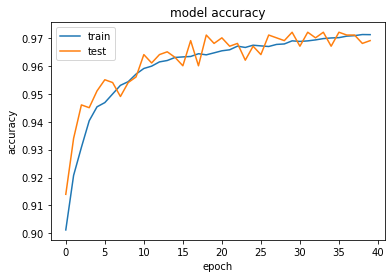

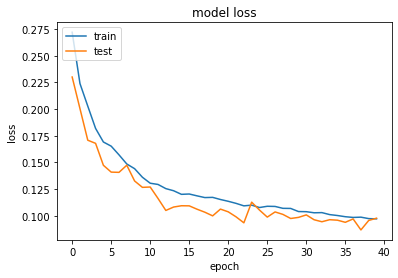

In [61]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
# model_cnn_base was never created

# y_baseline_pred = model_cnn_base.predict(X_te)
# fpr_baseline, tpr_baseline, thres_baseline = roc_curve(y_te_onehot[:,1], y_baseline_pred[:,1])
# auc_baseline = auc(fpr_baseline, tpr_baseline)
# print("Area under curve: {}".format(auc_baseline))

y_large_pred = model_cnn_large.predict(X_te)
fpr_large, tpr_large, thres_large = roc_curve(y_te_onehot[:,1], y_large_pred[:,1])
auc_large = auc(fpr_large, tpr_large)
print("Area under curve: {}".format(auc_large))

Area under curve: 0.9942277485569372


In [64]:
y_baseline_layers_pred = {}
fpr_baseline_layers = {}
tpr_baseline_layers = {}
thres_baseline_layers = {}
auc_baseline_layers = {}
for layer_i, layer_name in enumerate(layers):
    y_baseline_layers_pred[layer_i] = model_cnn_base_layers[layer_i].predict(x_cnn_te[layer_i])
    fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], thres_baseline_layers[layer_i] = roc_curve(y_cnn_te_onehot[layer_i][:,1], y_baseline_layers_pred[layer_i][:,1])
    auc_baseline_layers[layer_i] = auc(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i])
    print("Area under curve: {}".format(auc_baseline_layers[layer_i]))
#     y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
#     fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
#     auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
#     print("Area under curve: {}".format(auc_flat_nn[layer_i]))


Area under curve: 0.9917205785261338
Area under curve: 0.9935862852529518
Area under curve: 0.9821807009307009
Area under curve: 0.9511878574378575
Area under curve: 0.9320988244599354
Area under curve: 0.8812089332922668


In [65]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    model_cnn_base_layers[layer_i].save(modelpath+"model_{}_cnn_base.h5".format(layer_name))

Saving EMB1
Saving EMB2
Saving EMB3
Saving TileBar0
Saving TileBar1
Saving TileBar2


<Figure size 432x288 with 0 Axes>

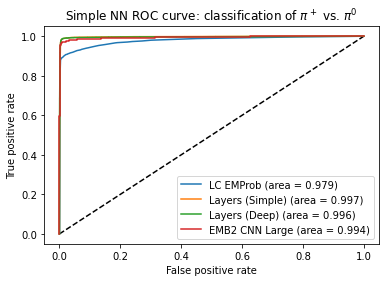

<Figure size 432x288 with 0 Axes>

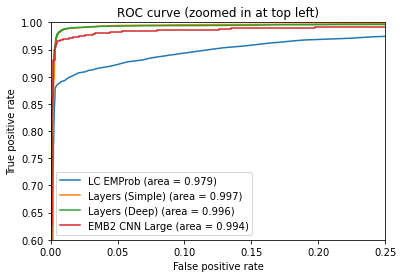

In [67]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
# plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
# plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_cnn.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

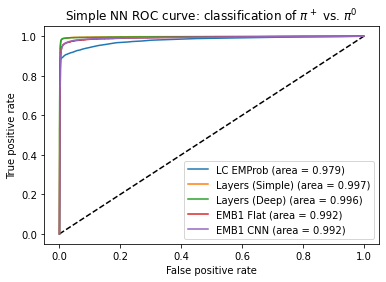

<Figure size 432x288 with 0 Axes>

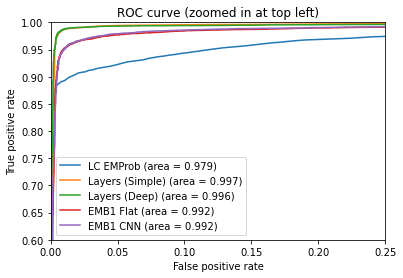

<Figure size 432x288 with 0 Axes>

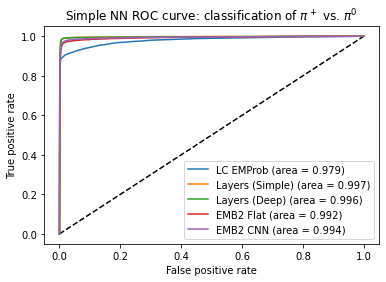

<Figure size 432x288 with 0 Axes>

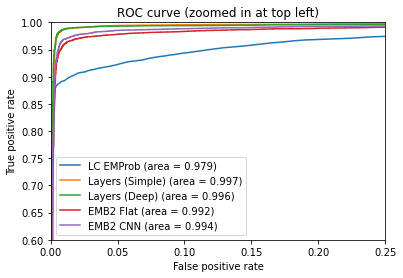

<Figure size 432x288 with 0 Axes>

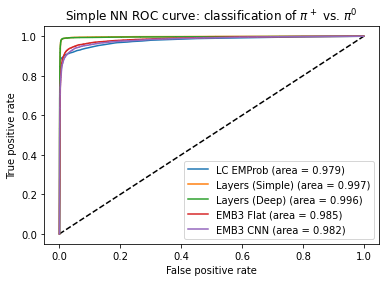

<Figure size 432x288 with 0 Axes>

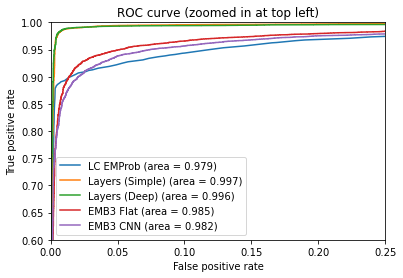

<Figure size 432x288 with 0 Axes>

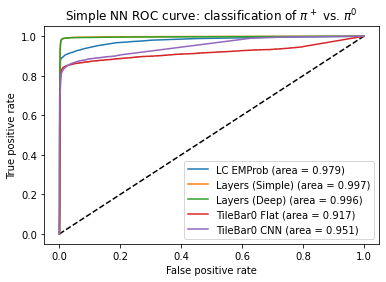

<Figure size 432x288 with 0 Axes>

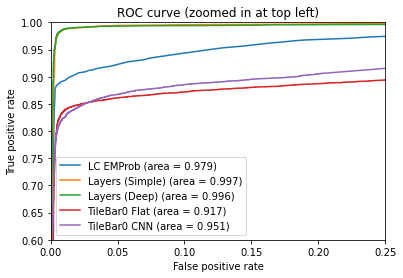

<Figure size 432x288 with 0 Axes>

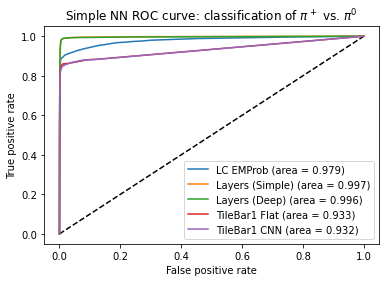

<Figure size 432x288 with 0 Axes>

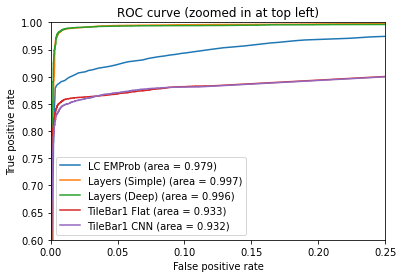

<Figure size 432x288 with 0 Axes>

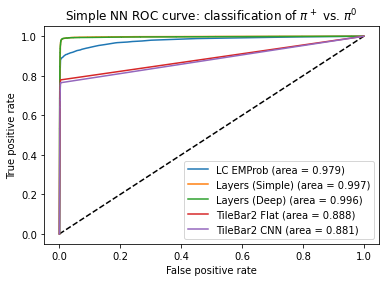

<Figure size 432x288 with 0 Axes>

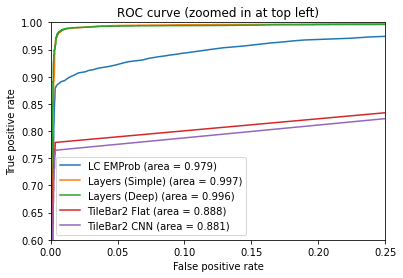

In [68]:
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()


    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    # Zoom in view of the upper left corner.
    plt.xlim(0, 0.25)
    plt.ylim(0.6, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    # ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_zoom_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [69]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# Mswiatlo-- let's do it on pi+ vs pi0

# This will allow it to be images, instead of flatenned, in emb1
# X0 = np.append(pp['EMB1'], p0['EMB1'], axis=0)

# flatten first layer (for now...) 
X0 = np.append(pp['EMB1'].reshape((len(pp['EMB1']),512)),
              p0['EMB1'].reshape((len(p0['EMB1']),512)), axis=0)

X1 = np.append(pp['EMB2'], p0['EMB2'], axis=0)
X2 = np.append(pp['EMB3'], p0['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
# X0 = X0.reshape(X0.shape[0], 1, 128, 4) #uncomment for images mode
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(pp['label'], p0['label'], axis=0)

print(X0.shape)
print(X1.shape)
print(X2.shape)
print(y.shape)

# split up into training and test datasets
# test_size = 4000
# validation_size = 1000
test_size = 8000 # double this, mswiatlo
validation_size = 2000 #double this, mswiatlo
from sklearn.model_selection import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print(X0_tr.shape)
print(y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(163653, 512)
(163653, 1, 16, 16)
(163653, 1, 8, 16)
(163653, 1)
(153653, 512)
(153653, 1)
y_train.shape:  (153653, 1)
y_train_onehot.shape:  (153653, 2)


In [71]:
# define convolutional model for multiple input images

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
# K.set_image_dim_ordering('th')

In [72]:
# create model

def merged_model_emb12():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [76]:
# build the model
model_merged_emb12 = merged_model_emb12()
model_merged_emb12.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 1, 16, 16)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 13, 13)   544         input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 32, 6, 6)     0           conv2d_9[0][0]                   
____________________________________________________________________________________________

In [77]:
# fit (train) the merged model
# remove [] from y train and valid to make it work
# history = model_merged_emb12.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)
history = model_merged_emb12.fit([X0_tr, X1_tr], y_tr_onehot, validation_data=([X0_vl, X1_vl], y_vl_onehot), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged_emb12.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/80
769/769 - 2s - loss: 0.4674 - accuracy: 0.7527 - val_loss: 0.2803 - val_accuracy: 0.8970
Epoch 2/80
769/769 - 2s - loss: 0.2628 - accuracy: 0.9011 - val_loss: 0.2659 - val_accuracy: 0.8990
Epoch 3/80
769/769 - 2s - loss: 0.2552 - accuracy: 0.9056 - val_loss: 0.2613 - val_accuracy: 0.9050
Epoch 4/80
769/769 - 2s - loss: 0.2490 - accuracy: 0.9081 - val_loss: 0.2470 - val_accuracy: 0.9105
Epoch 5/80
769/769 - 2s - loss: 0.1741 - accuracy: 0.9400 - val_loss: 0.1318 - val_accuracy: 0.9495
Epoch 6/80
769/769 - 2s - loss: 0.1430 - accuracy: 0.9535 - val_loss: 0.1655 - val_accuracy: 0.9350
Epoch 7/80
769/769 - 2s - loss: 0.1411 - accuracy: 0.9546 - val_loss: 0.2528 - val_accuracy: 0.9255
Epoch 8/80
769/769 - 2s - loss: 0.1351 - accuracy: 0.9570 - val_loss: 0.1566 - val_accuracy: 0.9405
Epoch 9/80
769/769 - 2s - loss: 0.1292 - accuracy: 0.9587 - val_loss: 0.1221 - val_accuracy: 0.9515
Epoch 10/80
769/769 - 2s - loss: 0.1334 - accuracy: 0.9576 - val_loss: 0.1386 - val_accuracy: 0.9460

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

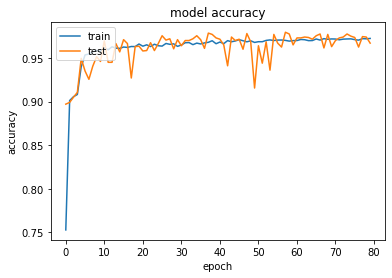

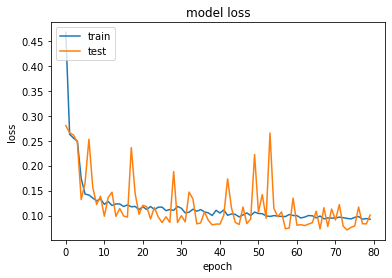

In [80]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

In [81]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb12.predict([X0_te, X1_te])
fpr_merge_emb12, tpr_merge_emb12, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge_emb12, tpr_merge_emb12)
print("Area under curve: {}".format(auc_merge))

Area under curve: 0.9948234017793682


<Figure size 432x288 with 0 Axes>

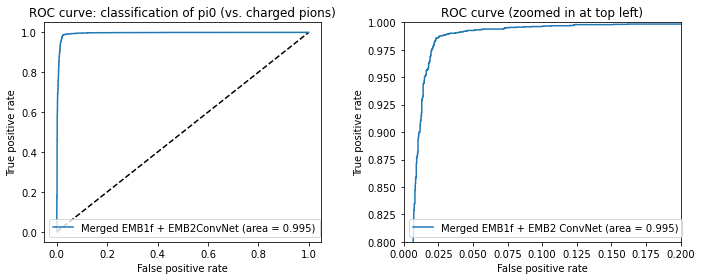

In [83]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
# ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [84]:
# create model

def merged_model_emb123():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu')(input3)
    x3 = MaxPooling2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [94]:
model_merged_emb123 = merged_model_emb123()
model_merged_emb123.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 1, 16, 16)]  0                                            
__________________________________________________________________________________________________
input3 (InputLayer)             [(None, 1, 8, 16)]   0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 13, 13)   544         input2[0][0]                     
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 7, 13)    288         input3[0][0]                     
____________________________________________________________________________________________

In [95]:
# fit (train) the merged model
# history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl, X2_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)
history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], y_tr_onehot, validation_data=([X0_vl, X1_vl, X2_vl], y_vl_onehot), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores_emb123 = model_merged_emb123.evaluate([X0_te, X1_te, X2_te], y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/80
769/769 - 3s - loss: 0.4894 - accuracy: 0.7305 - val_loss: 0.2716 - val_accuracy: 0.9020
Epoch 2/80
769/769 - 3s - loss: 0.2577 - accuracy: 0.9042 - val_loss: 0.2827 - val_accuracy: 0.8970
Epoch 3/80
769/769 - 3s - loss: 0.2479 - accuracy: 0.9087 - val_loss: 0.2500 - val_accuracy: 0.9065
Epoch 4/80
769/769 - 3s - loss: 0.2412 - accuracy: 0.9124 - val_loss: 0.2151 - val_accuracy: 0.9285
Epoch 5/80
769/769 - 3s - loss: 0.1703 - accuracy: 0.9444 - val_loss: 0.1740 - val_accuracy: 0.9590
Epoch 6/80
769/769 - 3s - loss: 0.1376 - accuracy: 0.9559 - val_loss: 0.1218 - val_accuracy: 0.9525
Epoch 7/80
769/769 - 3s - loss: 0.1286 - accuracy: 0.9595 - val_loss: 0.1169 - val_accuracy: 0.9545
Epoch 8/80
769/769 - 3s - loss: 0.1298 - accuracy: 0.9596 - val_loss: 0.1335 - val_accuracy: 0.9450
Epoch 9/80
769/769 - 3s - loss: 0.1265 - accuracy: 0.9614 - val_loss: 0.1071 - val_accuracy: 0.9640
Epoch 10/80
769/769 - 3s - loss: 0.1232 - accuracy: 0.9621 - val_loss: 0.1358 - val_accuracy: 0.9475

In [96]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb123.predict([X0_te, X1_te, X2_te])
fpr_merge_emb123, tpr_merge_emb123, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge_emb123 = auc(fpr_merge_emb123, tpr_merge_emb123)
print("Area under curve: {}".format(auc_merge_emb123))

Area under curve: 0.995282861125639


<Figure size 432x288 with 0 Axes>

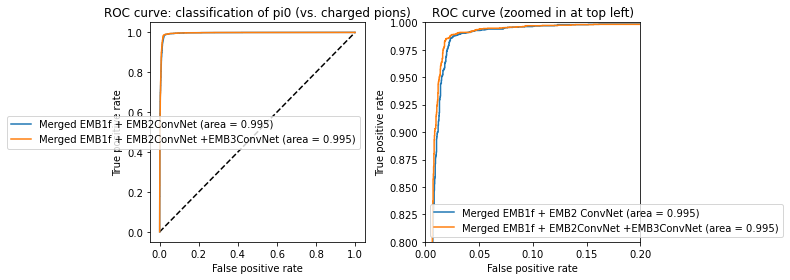

In [98]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
# ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

# Graph NN

In [119]:
len(X0_tr)

153653

In [131]:
import graph_nets as gn
import sonnet as snt

ImportError: cannot import name 'convert_to_tensor_v1_with_dispatch' from 'tensorflow.python.framework.ops' (/global/home/users/mfong/anaconda3/envs/tf2/lib/python3.8/site-packages/tensorflow/python/framework/ops.py)

In [130]:
!pip install graph_nets "tensorflow_gpu>=2.1.0-rc1" "dm-sonnet>=2.0.0b0" tensorflow_probability

  Using cached tensorboard-2.4.1-py3-none-any.whl (10.6 MB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0 requires tensorboard<2.3.0,>=2.2.0, but you have tensorboard 2.4.1 which is incompatible.
tensorflow 2.2.0 requires tensorflow-estimator<2.3.0,>=2.2.0, but you have tensorflow-estimator 2.4.0 which is incompatible.


In [132]:
tf.__version__

'2.2.0'